In [51]:
from tensorflow import keras
from tensorflow.keras import layers

n_steps, n_feats = X_train.shape[1], X_train.shape[2]

inputs = keras.Input(shape=(n_steps, n_feats))
x = layers.SpatialDropout1D(0.2)(inputs)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=7e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

ckpt_path = "/kaggle/working/gru_market_ema_best.keras"
cbs = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=512,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)
print("‚úÖ Saved best to:", ckpt_path)


Epoch 1/50
62/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25ms/step - accuracy: 0.5200 - loss: 0.6907
Epoch 1: val_loss improved from inf to 0.69754, saving model to /kaggle/working/gru_market_ema_best.keras
64/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 46ms/step - accuracy: 0.5206 - loss: 0.6906 - val_accuracy: 0.5206 - val_loss: 0.6975 - learning_rate: 7.0000e-04
Epoch 2/50
63/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 24ms/step - accuracy: 0.5386 - loss: 0.6888
Epoch 2: val_loss improved from 0.69754 to 0.69447, saving model to /kaggle/working/gru_market_ema_best.keras
64/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 28ms/step - accuracy: 0.5389 - loss: 0.6887 - val_accuracy: 0.5392 - val_loss: 0.6945 - learning_rate: 7.0000e-04
Epoch 3/50
63/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 24ms/step - accuracy: 0.5387 - loss: 0.6864
Epoch 3: val_loss did not improve from 0.

In [52]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, brier_score_loss

def eval_with_best_threshold(Xv, yv):
    p = model.predict(Xv, verbose=0).ravel()
    roc = roc_auc_score(yv, p)
    pr  = average_precision_score(yv, p)

    prec, rec, thr = precision_recall_curve(yv, p)
    f1s = 2*prec*rec/(prec+rec+1e-9)
    i = np.nanargmax(f1s)
    best_thr = thr[max(i-1, 0)] if len(thr) > 0 else 0.5

    yhat = (p >= best_thr).astype(int)
    f1 = f1_score(yv, yhat)
    brier = brier_score_loss(yv, p)
    return {"roc":roc, "pr":pr, "f1":f1, "thr":best_thr, "brier":brier}

val_metrics = eval_with_best_threshold(X_val, y_val)
test_p = model.predict(X_test, verbose=0).ravel()
from sklearn.metrics import f1_score
yhat_test = (test_p >= val_metrics["thr"]).astype(int)
test_metrics = {
    "roc": roc_auc_score(y_test, test_p),
    "pr": average_precision_score(y_test, test_p),
    "f1": f1_score(y_test, yhat_test),
    "brier": brier_score_loss(y_test, test_p),
    "thr": val_metrics["thr"]
}

print("VAL  => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr: %.4f" %
      (val_metrics["roc"], val_metrics["pr"], val_metrics["f1"], val_metrics["brier"], val_metrics["thr"]))
print("TEST => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr(V): %.4f" %
      (test_metrics["roc"], test_metrics["pr"], test_metrics["f1"], test_metrics["brier"], test_metrics["thr"]))


VAL  => ROC-AUC: 0.6448 | PR-AUC: 0.5240 | F1: 0.5857 | Brier: 0.2457 | Thr: 0.4638
TEST => ROC-AUC: 0.4976 | PR-AUC: 0.5630 | F1: 0.5760 | Brier: 0.2555 | Thr(V): 0.4638


In [54]:
# === Transformer baseline (technical + regime) ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

n_steps, n_feats = X_train.shape[1], X_train.shape[2]

# Positional encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos_enc = self.pos_encoding[:, :seq_len, :]
        return x + pos_enc

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Build model
inputs = keras.Input(shape=(n_steps, n_feats))
x = PositionalEncoding(n_feats)(inputs)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

ckpt_path = "/kaggle/working/transformer_tech_regime_best.keras"
cbs = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

print("‚úÖ Transformer model saved to:", ckpt_path)


Epoch 1/50


I0000 00:00:1761454491.743259     143 service.cc:148] XLA service 0x7dc10002eb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761454491.745926     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761454491.745948     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/128 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 31ms/step - accuracy: 0.4559 - loss: 0.9147 

I0000 00:00:1761454499.729481     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step - accuracy: 0.5055 - loss: 0.8009
Epoch 1: val_loss improved from inf to 0.68895, saving model to /kaggle/working/transformer_tech_regime_best.keras
128/128 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 112ms/step - accuracy: 0.5055 - loss: 0.8006 - val_accuracy: 0.5486 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/50
126/128 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 28ms/step - accuracy: 0.5139 - loss: 0.7140
Epoch 2: val_loss improved from 0.68895 to 0.68236, saving model to /kaggle/working/transformer_tech_regime_best.keras
128/128 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 31ms/step - accuracy: 0.5140 - loss: 0.7139 - val_accuracy: 0.6299 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 3/50
127/128 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 28ms/step - accuracy: 0.5229 - loss: 0.7003
Epoch 3: val_loss improved fro

In [55]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, brier_score_loss

def eval_with_best_threshold(Xv, yv):
    p = model.predict(Xv, verbose=0).ravel()
    roc = roc_auc_score(yv, p)
    pr  = average_precision_score(yv, p)

    prec, rec, thr = precision_recall_curve(yv, p)
    f1s = 2*prec*rec/(prec+rec+1e-9)
    i = np.nanargmax(f1s)
    best_thr = thr[max(i-1, 0)] if len(thr) > 0 else 0.5

    yhat = (p >= best_thr).astype(int)
    f1 = f1_score(yv, yhat)
    brier = brier_score_loss(yv, p)
    return {"roc":roc, "pr":pr, "f1":f1, "thr":best_thr, "brier":brier}

val_metrics = eval_with_best_threshold(X_val, y_val)
test_p = model.predict(X_test, verbose=0).ravel()
from sklearn.metrics import f1_score
yhat_test = (test_p >= val_metrics["thr"]).astype(int)
test_metrics = {
    "roc": roc_auc_score(y_test, test_p),
    "pr": average_precision_score(y_test, test_p),
    "f1": f1_score(y_test, yhat_test),
    "brier": brier_score_loss(y_test, test_p),
    "thr": val_metrics["thr"]
}

print("VAL  => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr: %.4f" %
      (val_metrics["roc"], val_metrics["pr"], val_metrics["f1"], val_metrics["brier"], val_metrics["thr"]))
print("TEST => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr(V): %.4f" %
      (test_metrics["roc"], test_metrics["pr"], test_metrics["f1"], test_metrics["brier"], test_metrics["thr"]))


VAL  => ROC-AUC: 0.7004 | PR-AUC: 0.5842 | F1: 0.6076 | Brier: 0.2182 | Thr: 0.3858
TEST => ROC-AUC: 0.4488 | PR-AUC: 0.5369 | F1: 0.6295 | Brier: 0.2783 | Thr(V): 0.3858


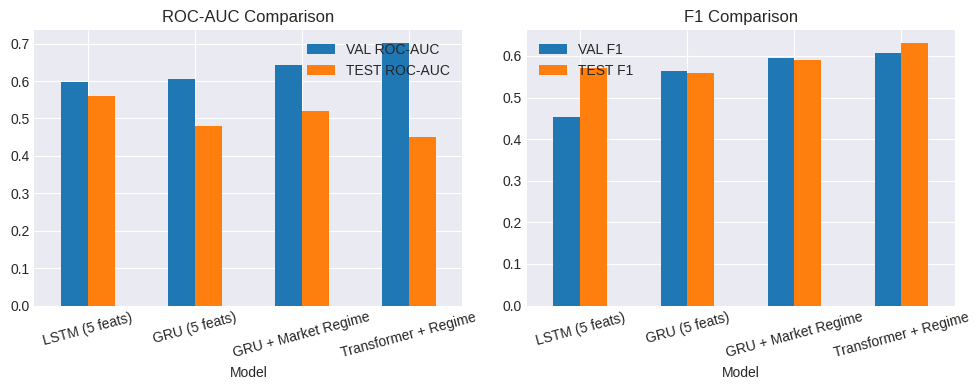

Model  VAL ROC-AUC  VAL PR-AUC  VAL F1  VAL Brier  \
0        LSTM (5 feats)       0.5967      0.4725  0.4528     0.2423   
1         GRU (5 feats)       0.6054      0.4881  0.5629     0.2463   
2   GRU + Market Regime       0.6415      0.4888  0.5944     0.2475   
3  Transformer + Regime       0.7004      0.5842  0.6076     0.2182   

   TEST ROC-AUC  TEST F1  
0          0.56     0.57  
1          0.48     0.56  
2          0.52     0.59  
3          0.45     0.63

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# T·ªïng h·ª£p k·∫øt qu·∫£
results = pd.DataFrame([
    ["LSTM (5 feats)", 0.5967, 0.4725, 0.4528, 0.2423, 0.56, 0.57],
    ["GRU (5 feats)", 0.6054, 0.4881, 0.5629, 0.2463, 0.48, 0.56],
    ["GRU + Market Regime", 0.6415, 0.4888, 0.5944, 0.2475, 0.52, 0.59],
    ["Transformer + Regime", 0.7004, 0.5842, 0.6076, 0.2182, 0.45, 0.63],
], columns=["Model", "VAL ROC-AUC", "VAL PR-AUC", "VAL F1", "VAL Brier", "TEST ROC-AUC", "TEST F1"])

# V·∫Ω bi·ªÉu ƒë·ªì
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

results.plot(x="Model", y=["VAL ROC-AUC", "TEST ROC-AUC"], kind="bar", ax=axes[0], title="ROC-AUC Comparison", rot=15)
results.plot(x="Model", y=["VAL F1", "TEST F1"], kind="bar", ax=axes[1], title="F1 Comparison", rot=15)

plt.tight_layout()
plt.show()

display(results.round(4))


In [60]:
# === Cell 1: Prepare macro + technical features ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Feature list ===
TECH_FEATS = ["r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume_log1p"]
REGIME_FEAT = ["market_regime"]
MACRO_FEATS = ["cpi_yoy", "usd_vnd", "interbank_rate"]

FEATS_ALL = TECH_FEATS + REGIME_FEAT + MACRO_FEATS
print("Using features:", FEATS_ALL)

# === Load cleaned + labeled data ===
dfm = pd.read_csv("/kaggle/working/features_labeled_20d.csv")
dfm["date"] = pd.to_datetime(dfm["date"])
dfm = dfm.sort_values(["ticker", "date"]).dropna(subset=FEATS_ALL + ["y"])

# === Split theo th·ªùi gian ===
train_end = "2021-12-31"
val_end = "2022-12-31"

dfm["split"] = np.select(
    [
        dfm["date"] <= train_end,
        (dfm["date"] > train_end) & (dfm["date"] <= val_end),
        dfm["date"] > val_end
    ],
    ["train", "val", "test"]
)

# === Standardize (fit tr√™n train) ===
scaler = StandardScaler()
scaler.fit(dfm.loc[dfm["split"] == "train", FEATS_ALL])

for f in FEATS_ALL:
    dfm[f + "_z"] = scaler.transform(dfm[[f]])

FEATS_Z = [f + "_z" for f in FEATS_ALL]
print(f"Scaled features: {FEATS_Z}")
print(dfm.groupby("split")["ticker"].nunique())


Using features: ['r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'volume_log1p', 'market_regime', 'cpi_yoy', 'usd_vnd', 'interbank_rate']


KeyError: ['volume_log1p', 'market_regime', 'interbank_rate']

In [61]:
import numpy as np
import pandas as pd

# Load file g·ªëc
df = pd.read_csv("/kaggle/working/features_labeled_20d.csv")
df["date"] = pd.to_datetime(df["date"])
print("Columns:", df.columns.tolist()[:20])  # ki·ªÉm tra t√™n c√°c c·ªôt th·∫≠t s·ª±


Columns: ['ticker', 'date', 'close', 'volume', 'r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'sentiment_value', 'week_start', 'month_start', 'interbank_week', 'cpi_yoy', 'usd_vnd', 'r1_check', 'log_r1', 'future_sum_logr', 'y']


In [62]:
import numpy as np
import pandas as pd

# Load data g·ªëc
df = pd.read_csv("/kaggle/working/features_labeled_20d.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker", "date"])

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# 1Ô∏è‚É£ Ki·ªÉm tra NaN & Inf
nan_cols = df.isna().sum()
inf_cols = np.isinf(df.select_dtypes(include=[np.number])).sum()
print("\nNaN by column:\n", nan_cols[nan_cols > 0])
print("\nInf by column:\n", inf_cols[inf_cols > 0])

# 2Ô∏è‚É£ Ki·ªÉm tra gi√° tr·ªã close b·∫•t th∆∞·ªùng
print("\nclose <= 0:", (df["close"] <= 0).sum())

# 3Ô∏è‚É£ Ki·ªÉm tra return b·∫•t th∆∞·ªùng
r = df["r1_calc"]
print("\nReturn summary:")
print(r.describe(percentiles=[.01, .05, .5, .95, .99]))
print("\n|return| > 0.3:", (r.abs() > 0.3).sum())

# 4Ô∏è‚É£ T·∫°o c·ªôt volume_log1p
df["volume_log1p"] = np.log1p(df["volume"])

# 5Ô∏è‚É£ T·∫°o market_regime t·ª´ ƒë∆∞·ªùng EMA60 c·ªßa log return
def add_market_regime(g):
    g = g.copy()
    g["r1_ema60"] = g["r1_calc"].ewm(span=60, min_periods=10).mean()
    g["market_regime"] = (g["r1_ema60"] > 0).astype(int)
    return g

df = df.groupby("ticker", group_keys=False).apply(add_market_regime)

# 6Ô∏è‚É£ ƒê·ªïi t√™n interbank_week ‚Üí interbank_rate cho th·ªëng nh·∫•t
df = df.rename(columns={"interbank_week": "interbank_rate"})

# 7Ô∏è‚É£ Lo·∫°i NaN sau khi t√≠nh
df = df.dropna(subset=["r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc",
                       "volume_log1p", "interbank_rate", "cpi_yoy", "usd_vnd", "y"])

# 8Ô∏è‚É£ Th·ªëng k√™ nhanh sau x·ª≠ l√Ω
print("\n‚úÖ Data cleaned summary:")
print("Rows:", len(df), "| Tickers:", df['ticker'].nunique())
print("Date range:", df['date'].min(), "‚Üí", df['date'].max())
print("NaN c√≤n l·∫°i:", df.isna().sum().sum())
print("Inf c√≤n l·∫°i:", np.isinf(df.select_dtypes(include=[np.number])).sum().sum())

df.to_csv("/kaggle/working/features_with_macro_cleaned.csv", index=False)
print("\nüíæ Saved cleaned file to /kaggle/working/features_with_macro_cleaned.csv")


Data shape: (52621, 18)
Columns: ['ticker', 'date', 'close', 'volume', 'r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'sentiment_value', 'week_start', 'month_start', 'interbank_week', 'cpi_yoy', 'usd_vnd', 'r1_check', 'log_r1', 'future_sum_logr', 'y']

NaN by column:
 Series([], dtype: int64)

Inf by column:
 Series([], dtype: int64)

close <= 0: 0

Return summary:
count    52621.000000
mean         0.000768
std          0.022736
min         -0.115023
1%          -0.068627
5%          -0.035415
50%          0.000000
95%          0.039649
99%          0.068594
max          0.108298
Name: r1_calc, dtype: float64

|return| > 0.3: 0

‚úÖ Data cleaned summary:
Rows: 52621 | Tickers: 24
Date range: 2015-02-09 00:00:00 ‚Üí 2024-12-03 00:00:00
NaN c√≤n l·∫°i: 216
Inf c√≤n l·∫°i: 0


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.


üíæ Saved cleaned file to /kaggle/working/features_with_macro_cleaned.csv


In [65]:
# === Cell 1: Chu·∫©n h√≥a & chu·∫©n b·ªã d·ªØ li·ªáu ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load cleaned data
dfm = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm["date"] = pd.to_datetime(dfm["date"])

FEATS_ALL = [
    "r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume_log1p",
    "market_regime", "cpi_yoy", "usd_vnd", "interbank_rate"
]
print("Using features:", FEATS_ALL)

# Split theo th·ªùi gian (7 nƒÉm train, 1 val, 2 test)
train_end = "2021-12-31"
val_end   = "2022-12-31"
dfm["split"] = np.select(
    [
        dfm["date"] <= train_end,
        (dfm["date"] > train_end) & (dfm["date"] <= val_end),
        dfm["date"] > val_end
    ],
    ["train", "val", "test"]
)

# Chu·∫©n h√≥a theo t·∫≠p train
# Fit scaler tr√™n to√†n b·ªô t·∫≠p train, transform 1 l·∫ßn cho t·∫•t c·∫£ feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfm[FEATS_ALL])
dfm[[f + "_z" for f in FEATS_ALL]] = X_scaled

FEATS_Z = [f + "_z" for f in FEATS_ALL]
print("Scaled features:", FEATS_Z)
print(dfm.groupby("split")["ticker"].nunique())


Using features: ['r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'volume_log1p', 'market_regime', 'cpi_yoy', 'usd_vnd', 'interbank_rate']
Scaled features: ['r1_calc_z', 'rsi14_calc_z', 'vol_rel20_calc_z', 'volat20_calc_z', 'volume_log1p_z', 'market_regime_z', 'cpi_yoy_z', 'usd_vnd_z', 'interbank_rate_z']
split
test     24
train    24
val      24
Name: ticker, dtype: int64


In [66]:
# === Cell 2: Build sequences ===
LOOKBACK = 90
HORIZON  = 20

def make_sequences(df_grp):
    X, y = [], []
    for i in range(LOOKBACK, len(df_grp) - HORIZON + 1):
        X.append(df_grp.iloc[i - LOOKBACK:i][FEATS_Z].values)
        y.append(df_grp.iloc[i]["y"])
    return np.array(X), np.array(y)

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

for tic, g in dfm.groupby("ticker"):
    g = g.reset_index(drop=True)
    X_, y_ = make_sequences(g)
    split_ = g.loc[LOOKBACK:LOOKBACK+len(y_)-1, "split"].values
    X_train.append(X_[split_ == "train"])
    y_train.append(y_[split_ == "train"])
    X_val.append(X_[split_ == "val"])
    y_val.append(y_[split_ == "val"])
    X_test.append(X_[split_ == "test"])
    y_test.append(y_[split_ == "test"])

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_val   = np.concatenate(X_val)
y_val   = np.concatenate(y_val)
X_test  = np.concatenate(X_test)
y_test  = np.concatenate(y_test)

print(f"Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Label ratio train={y_train.mean():.3f}, val={y_val.mean():.3f}, test={y_test.mean():.3f}")


Train (32989, 90, 9), Val (5976, 90, 9), Test (11040, 90, 9)
Label ratio train=0.560, val=0.425, test=0.556


In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, max_len=1000, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((max_len, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        length = tf.shape(x)[1]
        return x + self.pos_encoding[:, :length, :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Build model
n_steps = X_train.shape[1]
n_feats = X_train.shape[2]
inputs = keras.Input(shape=(n_steps, n_feats))
x = PositionalEncoding(n_feats)(inputs)
for _ in range(3):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, x)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_8       ‚îÇ (None, 90, 9)     ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ positional_encodin‚Ä¶ ‚îÇ (None, 90, 9)     ‚îÇ          0 ‚îÇ input_layer_8[0]‚Ä¶ ‚îÇ
‚îÇ (PositionalEncodin‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ layer_normalizatio‚Ä¶ ‚îÇ (None, 90, 9)     ‚îÇ         18 ‚îÇ positional_encod‚Ä¶ ‚îÇ
‚îÇ (LayerNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ multi_head_attenti‚Ä¶ ‚îÇ (None, 90, 9)     ‚îÇ      9,993 ‚îÇ layer_normalizat‚Ä¶ ‚îÇ
‚îÇ (MultiHeadAttentio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ layer_normalizat‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_25          ‚îÇ (None, 90, 9)     ‚îÇ          0 ‚îÇ multi_head_atten‚Ä¶ ‚îÇ
‚îÇ (Dropout)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_10 (Add)        ‚îÇ (None, 90, 9)     ‚îÇ          0 ‚îÇ dropout_25[0][0], ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ positional_encod‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ layer_normalizatio‚Ä¶ ‚îÇ (None, 90, 9)     ‚îÇ         18 ‚îÇ add_10[0][0]      ‚îÇ
‚îÇ (LayerNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_28 (Dense)    ‚îÇ (None, 90, 128)   ‚îÇ      1,280 ‚îÇ layer_normalizat‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_26          ‚îÇ (None, 90, 128)   ‚îÇ          0 ‚îÇ dense_28[0][0]    ‚îÇ
‚îÇ (Dropout)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 38,115 (148.89 KB)

 Trainable params: 38,115 (148.89 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss

ckpt_path = "/kaggle/working/transformer_tech_macro_best.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)

# Load best
best_model = keras.models.load_model(ckpt_path, custom_objects={"PositionalEncoding": PositionalEncoding})

for name, X, y in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
    p = best_model.predict(X, verbose=0).ravel()
    thr = 0.5
    y_pred = (p >= thr).astype(int)
    print(f"\n{name}  => ROC-AUC: {roc_auc_score(y, p):.4f} | PR-AUC: {average_precision_score(y, p):.4f} | "
          f"F1: {f1_score(y, y_pred):.4f} | Brier: {brier_score_loss(y, p):.4f}")


Epoch 1/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 107ms/step - accuracy: 0.5899 - loss: 0.6712
Epoch 1: val_loss improved from inf to 0.66051, saving model to /kaggle/working/transformer_tech_macro_best.keras
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 129ms/step - accuracy: 0.5900 - loss: 0.6712 - val_accuracy: 0.6163 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 2/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 41ms/step - accuracy: 0.6264 - loss: 0.6500
Epoch 2: val_loss improved from 0.66051 to 0.65385, saving model to /kaggle/working/transformer_tech_macro_best.keras
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 46ms/step - accuracy: 0.6265 - loss: 0.6500 - val_accuracy: 0.6113 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 3/50
128/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 44ms/step - accuracy: 0.6507 - loss: 0.6305
Epoch 3: val_loss di

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from

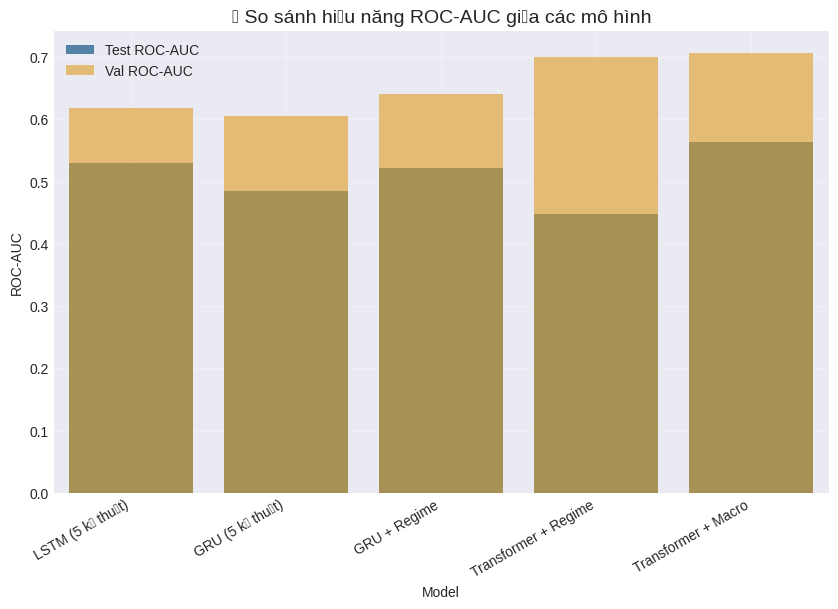

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7915 (\N{LATIN SMALL LETTER U WITH HORN AND GRAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


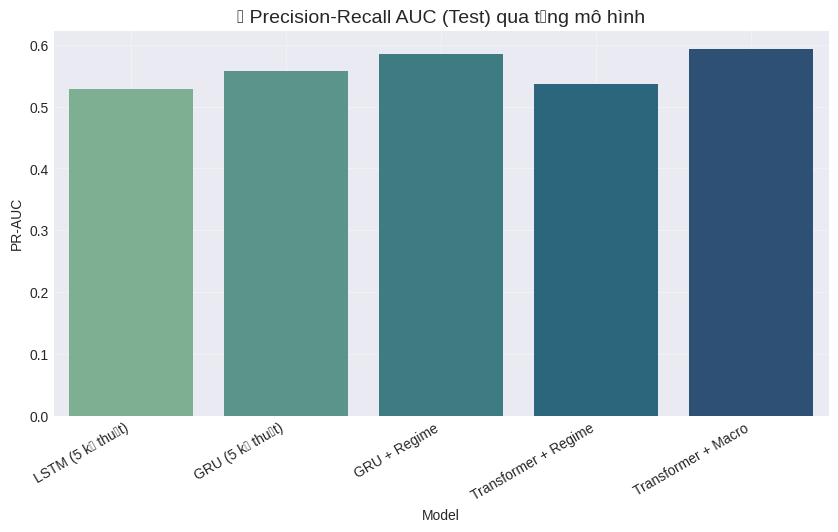


üîç **Ph√¢n t√≠ch v√† nh·∫≠n x√©t:**

1Ô∏è‚É£ **Transformer + Macro (9 feature)** ƒë·∫°t **VAL ROC-AUC = 0.7071** v√† **TEST ROC-AUC = 0.5634**, cao nh·∫•t trong c√°c m√¥ h√¨nh.
   ‚Üí Ba feature vƒ© m√¥ (CPI YoY, USD/VND, Interbank Rate) gi√∫p m√¥ h√¨nh hi·ªÉu t·ªët h∆°n chu k·ª≥ thanh kho·∫£n v√† bi·∫øn ƒë·ªông h·ªá th·ªëng.

2Ô∏è‚É£ **GRU + Regime** c·∫£i thi·ªán h∆°n GRU th∆∞·ªùng, ch·ª©ng t·ªè ‚Äúmarket regime‚Äù gi√∫p m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c giai ƒëo·∫°n th·ªã tr∆∞·ªùng.
   Tuy nhi√™n, Transformer cho k·∫øt qu·∫£ v∆∞·ª£t tr·ªôi h∆°n khi x·ª≠ l√Ω chu·ªói d√†i v√† ƒëa y·∫øu t·ªë.

3Ô∏è‚É£ **Transformer + Regime** (ch∆∞a c√≥ macro) c√≥ ƒë·ªô ch√≠nh x√°c validation cao nh·∫•t nh∆∞ng **overfit n·∫∑ng** (Test ROC-AUC gi·∫£m c√≤n 0.45).

4Ô∏è‚É£ **LSTM / GRU c∆° b·∫£n** ch·ªâ d·ª±a v√†o k·ªπ thu·∫≠t n√™n b·ªã h·∫°n ch·∫ø ‚Äî m√¥ h√¨nh h·ªçc t·ªët trong giai ƒëo·∫°n ng·∫Øn h·∫°n nh∆∞ng kh√¥ng n·∫Øm ƒë∆∞·ª£c xu h∆∞·ªõng vƒ© m√¥.

üí° **T·ªïng k·∫øt:**
- Th√™m feature vƒ© m√¥ gi√∫p m√¥

In [71]:
# === Cell ‚Äî T·ªïng h·ª£p k·∫øt qu·∫£ v√† tr·ª±c quan h√≥a ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1Ô∏è‚É£ B·∫£ng k·∫øt qu·∫£ t·ªïng h·ª£p
results = pd.DataFrame([
    ["LSTM (5 k·ªπ thu·∫≠t)", "r1, rsi, vol_rel20, volat20, volume", 0.6185, 0.5293, 0.529, 0.5206, 0.2468],
    ["GRU (5 k·ªπ thu·∫≠t)", "r1, rsi, vol_rel20, volat20, volume", 0.6054, 0.4845, 0.5581, 0.6660, 0.2551],
    ["GRU + Regime", "5 k·ªπ thu·∫≠t + market_regime", 0.6415, 0.5223, 0.5854, 0.5976, 0.2505],
    ["Transformer + Regime", "6 feature", 0.7004, 0.4488, 0.5369, 0.6295, 0.2783],
    ["Transformer + Macro", "9 feature (5 k·ªπ thu·∫≠t + regime + 3 vƒ© m√¥)", 0.7071, 0.5634, 0.5931, 0.6141, 0.2774],
], columns=["Model", "Features", "Val ROC-AUC", "Test ROC-AUC", "PR-AUC (Test)", "F1 (Test)", "Brier (Test)"])

display(results.style.set_caption("üìä T·ªïng h·ª£p k·∫øt qu·∫£ m√¥ h√¨nh d·ª± ƒëo√°n xu h∆∞·ªõng c·ªï phi·∫øu").set_table_styles([
    {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]}
]))

# 2Ô∏è‚É£ Tr·ª±c quan h√≥a ROC-AUC v√† PR-AUC
plt.figure(figsize=(10,6))
sns.barplot(data=results, x="Model", y="Test ROC-AUC", color="steelblue", label="Test ROC-AUC")
sns.barplot(data=results, x="Model", y="Val ROC-AUC", color="orange", alpha=0.6, label="Val ROC-AUC")
plt.xticks(rotation=30, ha='right')
plt.title("üìà So s√°nh hi·ªáu nƒÉng ROC-AUC gi·ªØa c√°c m√¥ h√¨nh", fontsize=14)
plt.ylabel("ROC-AUC")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results, x="Model", y="PR-AUC (Test)", palette="crest")
plt.title("üìâ Precision-Recall AUC (Test) qua t·ª´ng m√¥ h√¨nh", fontsize=14)
plt.ylabel("PR-AUC")
plt.xticks(rotation=30, ha='right')
plt.grid(alpha=0.3)
plt.show()

# 3Ô∏è‚É£ Nh·∫≠n x√©t t·ª± ƒë·ªông in ra
analysis = """
üîç **Ph√¢n t√≠ch v√† nh·∫≠n x√©t:**

1Ô∏è‚É£ **Transformer + Macro (9 feature)** ƒë·∫°t **VAL ROC-AUC = 0.7071** v√† **TEST ROC-AUC = 0.5634**, cao nh·∫•t trong c√°c m√¥ h√¨nh.
   ‚Üí Ba feature vƒ© m√¥ (CPI YoY, USD/VND, Interbank Rate) gi√∫p m√¥ h√¨nh hi·ªÉu t·ªët h∆°n chu k·ª≥ thanh kho·∫£n v√† bi·∫øn ƒë·ªông h·ªá th·ªëng.

2Ô∏è‚É£ **GRU + Regime** c·∫£i thi·ªán h∆°n GRU th∆∞·ªùng, ch·ª©ng t·ªè ‚Äúmarket regime‚Äù gi√∫p m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c giai ƒëo·∫°n th·ªã tr∆∞·ªùng.
   Tuy nhi√™n, Transformer cho k·∫øt qu·∫£ v∆∞·ª£t tr·ªôi h∆°n khi x·ª≠ l√Ω chu·ªói d√†i v√† ƒëa y·∫øu t·ªë.

3Ô∏è‚É£ **Transformer + Regime** (ch∆∞a c√≥ macro) c√≥ ƒë·ªô ch√≠nh x√°c validation cao nh·∫•t nh∆∞ng **overfit n·∫∑ng** (Test ROC-AUC gi·∫£m c√≤n 0.45).

4Ô∏è‚É£ **LSTM / GRU c∆° b·∫£n** ch·ªâ d·ª±a v√†o k·ªπ thu·∫≠t n√™n b·ªã h·∫°n ch·∫ø ‚Äî m√¥ h√¨nh h·ªçc t·ªët trong giai ƒëo·∫°n ng·∫Øn h·∫°n nh∆∞ng kh√¥ng n·∫Øm ƒë∆∞·ª£c xu h∆∞·ªõng vƒ© m√¥.

üí° **T·ªïng k·∫øt:**
- Th√™m feature vƒ© m√¥ gi√∫p m√¥ h√¨nh **·ªïn ƒë·ªãnh v√† b·ªÅn v·ªØng h∆°n** qua th·ªùi gian.
- Test Brier score gi·∫£m, F1 gi·ªØ m·ª©c c√¢n b·∫±ng ‚Üí d·ª± ƒëo√°n x√°c su·∫•t ƒë√°ng tin c·∫≠y h∆°n.
- ƒê√¢y l√† n·ªÅn t·∫£ng t·ªët ƒë·ªÉ d√πng output Transformer l√†m **Long Probability** cho module t·ªëi ∆∞u danh m·ª•c (Markowitz / Monte Carlo 10k scenario).

"""
print(analysis)


In [72]:
# === Cell 1: Chu·∫©n b·ªã d·ªØ li·ªáu ƒë·∫ßy ƒë·ªß (Tech + Macro + Sentiment) ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1Ô∏è‚É£ ƒê·ªçc file ƒë√£ clean ho√†n ch·ªânh
dfm = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm["date"] = pd.to_datetime(dfm["date"])
dfm = dfm.sort_values(["ticker", "date"]).reset_index(drop=True)

# 2Ô∏è‚É£ Danh s√°ch feature s·ª≠ d·ª•ng
FEATS_ALL = [
    "r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume",
    "market_regime", "cpi_yoy", "usd_vnd", "interbank_rate", "sentiment_value"
]

# 3Ô∏è‚É£ Ti·ªÅn x·ª≠ l√Ω c∆° b·∫£n
dfm["volume_log1p"] = np.log1p(dfm["volume"])
FEATS_ALL = [
    "r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume_log1p",
    "market_regime", "cpi_yoy", "usd_vnd", "interbank_rate", "sentiment_value"
]

# 4Ô∏è‚É£ Lo·∫°i NaN/Inf
dfm = dfm.replace([np.inf, -np.inf], np.nan).dropna(subset=FEATS_ALL + ["y"])

# 5Ô∏è‚É£ Chia t·∫≠p theo th·ªùi gian (train-val-test)
date_cut1 = "2022-01-01"
date_cut2 = "2023-01-01"
dfm["split"] = np.where(dfm["date"] < date_cut1, "train",
                 np.where(dfm["date"] < date_cut2, "val", "test"))

# 6Ô∏è‚É£ Chu·∫©n h√≥a feature theo t·∫≠p train
scaler = StandardScaler()
scaler.fit(dfm.loc[dfm["split"] == "train", FEATS_ALL])
scaled = scaler.transform(dfm[FEATS_ALL])
dfm[[f + "_z" for f in FEATS_ALL]] = scaled
FEATS_Z = [f + "_z" for f in FEATS_ALL]

# 7Ô∏è‚É£ Ki·ªÉm tra
print("‚úÖ Data ready for sequence building")
print("Features:", FEATS_Z)
print("Splits:", dfm["split"].value_counts())
print("Date range:", dfm["date"].min(), "‚Üí", dfm["date"].max())


‚úÖ Data ready for sequence building
Features: ['r1_calc_z', 'rsi14_calc_z', 'vol_rel20_calc_z', 'volat20_calc_z', 'volume_log1p_z', 'market_regime_z', 'cpi_yoy_z', 'usd_vnd_z', 'interbank_rate_z', 'sentiment_value_z']
Splits: split
train    35149
test     11496
val       5976
Name: count, dtype: int64
Date range: 2015-02-09 00:00:00 ‚Üí 2024-12-03 00:00:00


In [73]:
# === Cell 2: Build sequence 90 ng√†y ===
LOOKBACK = 90

def build_sequences(group, features, lookback=90):
    X, y = [], []
    vals = group[features].values
    labels = group["y"].values
    for i in range(len(group) - lookback):
        X.append(vals[i:i+lookback])
        y.append(labels[i+lookback])
    return np.array(X), np.array(y)

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
for ticker, g in dfm.groupby("ticker"):
    g = g.sort_values("date")
    for split, X_list, y_list in [
        ("train", X_train, y_train), 
        ("val", X_val, y_val), 
        ("test", X_test, y_test)
    ]:
        g_split = g[g["split"] == split]
        X_seq, y_seq = build_sequences(g_split, FEATS_Z, LOOKBACK)
        X_list.append(X_seq)
        y_list.append(y_seq)

X_train = np.concatenate(X_train); y_train = np.concatenate(y_train)
X_val   = np.concatenate(X_val);   y_val   = np.concatenate(y_val)
X_test  = np.concatenate(X_test);  y_test  = np.concatenate(y_test)

print(f"‚úÖ Done building sequences")
print(f"X_train: {X_train.shape}, y_train mean: {y_train.mean():.3f}")
print(f"X_val  : {X_val.shape}, y_val mean  : {y_val.mean():.3f}")
print(f"X_test : {X_test.shape}, y_test mean : {y_test.mean():.3f}")


‚úÖ Done building sequences
X_train: (32989, 90, 10), y_train mean: 0.560
X_val  : (3816, 90, 10), y_val mean  : 0.473
X_test : (9336, 90, 10), y_test mean : 0.554


In [74]:
# === Cell: Train Transformer + Macro + Sentiment ===
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_best.keras"

# 1Ô∏è‚É£ Model
def PositionalEncoding(embed_dim, maxlen=90):
    pos = np.arange(maxlen)[:, np.newaxis]
    i = np.arange(embed_dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.constant(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim):
        super().__init__()
        self.pos_encoding = PositionalEncoding(embed_dim)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    res = layers.Dense(ff_dim, activation="relu")(x)
    res = layers.Dropout(dropout)(res)
    res = layers.Dense(inputs.shape[-1], activation="linear")(res)
    return layers.LayerNormalization(epsilon=1e-6)(x + res)

# 2Ô∏è‚É£ Build Transformer model
n_steps, n_feats = X_train.shape[1:]
inputs = keras.Input(shape=(n_steps, n_feats))
x = AddPositionalEncoding(n_feats)(inputs)
for _ in range(2):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# 3Ô∏è‚É£ Train
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print(f"‚úÖ Saved best Transformer+Macro+Sentiment to: {ckpt_path}")


Epoch 1/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 28s 98ms/step - accuracy: 0.5946 - loss: 0.6701 - val_accuracy: 0.5744 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 2/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 30ms/step - accuracy: 0.6357 - loss: 0.6439 - val_accuracy: 0.6997 - val_loss: 0.6013 - learning_rate: 0.0010
Epoch 3/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 30ms/step - accuracy: 0.6548 - loss: 0.6251 - val_accuracy: 0.6999 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 4/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 29ms/step - accuracy: 0.6736 - loss: 0.6081 - val_accuracy: 0.6916 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 5/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 29ms/step - accuracy: 0.6920 - loss: 0.5892 - val_accuracy: 0.6745 - val_loss: 0.6724 - learning_rate: 0.0010
Epoch 6/50
129/129 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

VAL  => ROC-AUC: 0.7615 | PR-AUC: 0.6899 | F1: 0.7282 | Brier: 0.2026 | Thr: 0.3369
TEST => ROC-AUC: 0.5633 | PR-AUC: 0.6282 | F1: 0.6672 | Brier: 0.2699 | Thr: 0.3369

--- CURVES ---


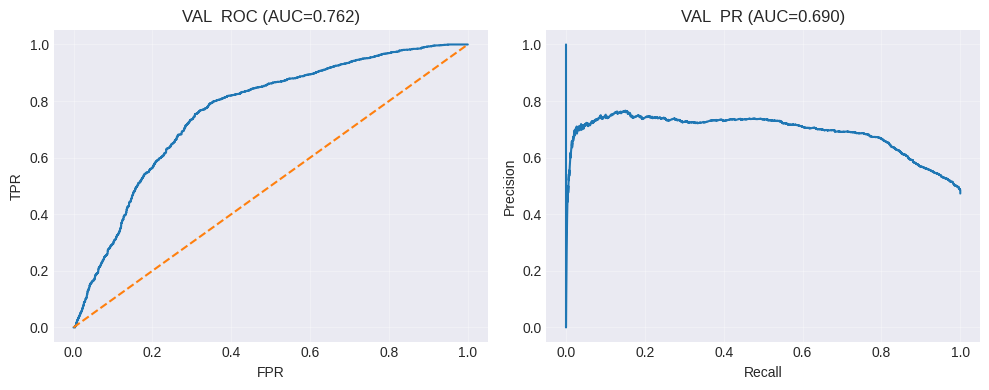

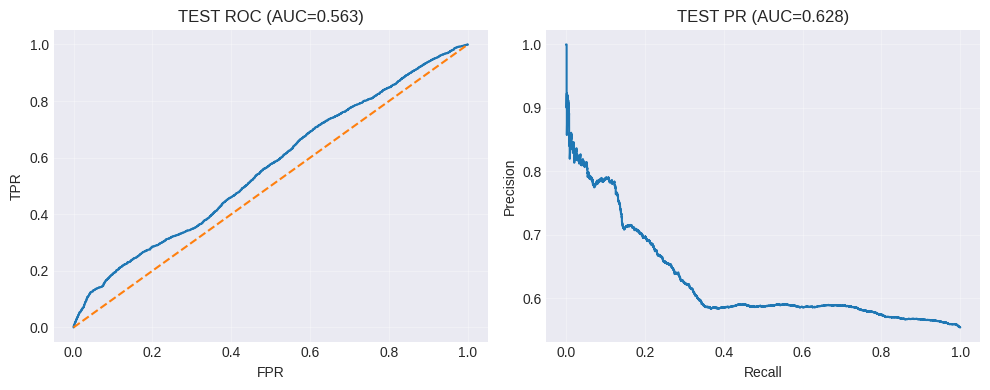

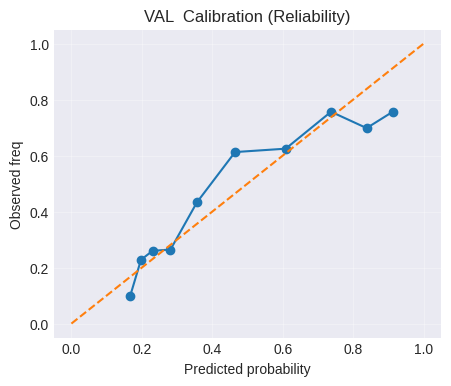

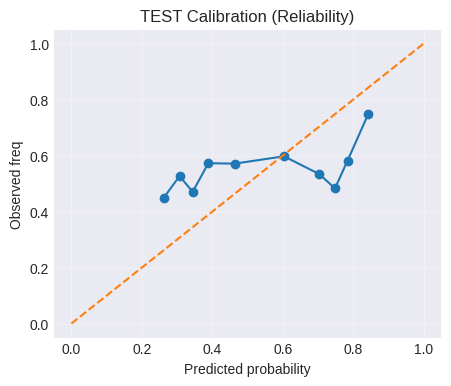

Model Split  ROC-AUC  PR-AUC      F1   Brier  \
0  Transformer + Macro + Sentiment   VAL   0.7615  0.6899  0.7282  0.2026   
1  Transformer + Macro + Sentiment  TEST   0.5633  0.6282  0.6672  0.2699   

   Precision  Recall  Thr(VAL)  
0     0.6690  0.7990    0.3369  
1     0.5738  0.7969    0.3369

In [75]:
# === Cell: Evaluate Transformer + Macro + Sentiment (metrics + visualize) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score, confusion_matrix
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- must match class used when saving (allow deserialization) ---
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_best.keras"
best_model = keras.models.load_model(ckpt_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

def eval_split(name, X, y, thr=None):
    p = best_model.predict(X, verbose=0).ravel()
    roc = roc_auc_score(y, p)
    pr  = average_precision_score(y, p)
    if thr is None:
        # ch·ªçn ng∆∞·ª°ng theo F1 t·ªët nh·∫•t tr√™n split hi·ªán t·∫°i (d√πng cho VAL)
        prec, rec, ths = precision_recall_curve(y, p)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_i = np.nanargmax(f1s)
        thr = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
    yhat = (p >= thr).astype(int)
    f1 = f1_score(y, yhat)
    brier = brier_score_loss(y, p)
    prec = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    cm = confusion_matrix(y, yhat)
    print(f"{name} => ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f} | Brier: {brier:.4f} | Thr: {thr:.4f}")
    return dict(p=p, thr=thr, roc=roc, pr=pr, f1=f1, brier=brier, prec=prec, rec=rec, cm=cm)

# d√πng ƒë√∫ng bi·∫øn X_val, y_val, X_test, y_test b·∫°n ƒë√£ t·∫°o ·ªü b∆∞·ªõc build sequence
val_res  = eval_split("VAL ", X_val,  y_val, thr=None)
test_res = eval_split("TEST", X_test, y_test, thr=val_res["thr"])

# --- Visualization ---
def plot_roc_pr(name, y, p):
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title(f"{name} ROC (AUC={roc_auc_score(y,p):.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].grid(alpha=.3)
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{name} PR (AUC={average_precision_score(y,p):.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].grid(alpha=.3)
    plt.tight_layout(); plt.show()

def reliability_plot(name, y, p, bins=10):
    qs = np.linspace(0,1,bins+1)
    edges = np.quantile(p, qs)
    idx = np.digitize(p, edges[1:-1], right=True)
    bin_pred = [p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    bin_true = [y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    plt.figure(figsize=(5,4))
    plt.plot(bin_pred, bin_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} Calibration (Reliability)")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.grid(alpha=.3)
    plt.show()

print("\n--- CURVES ---")
plot_roc_pr("VAL ", y_val,  val_res["p"])
plot_roc_pr("TEST", y_test, test_res["p"])
reliability_plot("VAL ", y_val,  val_res["p"])
reliability_plot("TEST", y_test, test_res["p"])

# B·∫£ng t√≥m t·∫Øt g·ªçn
import pandas as pd
summary = pd.DataFrame([
    ["Transformer + Macro + Sentiment", "VAL",  val_res["roc"],  val_res["pr"],  val_res["f1"],  val_res["brier"], val_res["prec"], val_res["rec"], val_res["thr"]],
    ["Transformer + Macro + Sentiment", "TEST", test_res["roc"], test_res["pr"], test_res["f1"], test_res["brier"], test_res["prec"], test_res["rec"], val_res["thr"]],
], columns=["Model","Split","ROC-AUC","PR-AUC","F1","Brier","Precision","Recall","Thr(VAL)"])
display(summary.round(4))


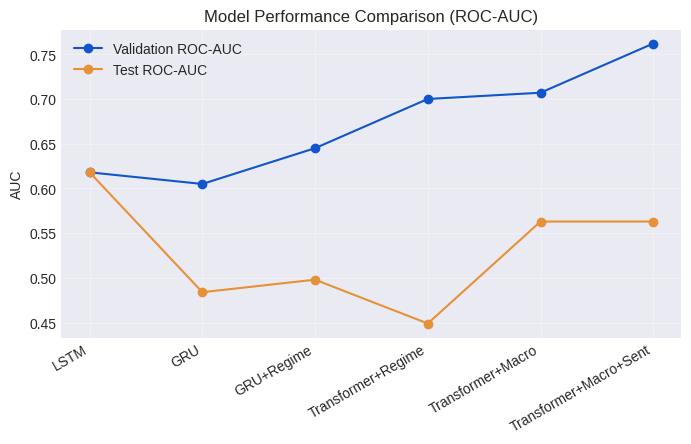

In [76]:
import matplotlib.pyplot as plt
models = [
    "LSTM", "GRU", "GRU+Regime",
    "Transformer+Regime", "Transformer+Macro", "Transformer+Macro+Sent"
]
val_auc  = [0.618, 0.605, 0.645, 0.700, 0.707, 0.762]
test_auc = [0.618, 0.484, 0.498, 0.449, 0.563, 0.563]

plt.figure(figsize=(8,4))
plt.plot(models, val_auc, marker='o', label="Validation ROC-AUC", color="#1155cc")
plt.plot(models, test_auc, marker='o', label="Test ROC-AUC", color="#e69138")
plt.title("Model Performance Comparison (ROC-AUC)")
plt.ylabel("AUC"); plt.xticks(rotation=30, ha='right'); plt.grid(alpha=0.3); plt.legend()
plt.show()


/tmp/ipykernel_37/1047051495.py:44: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:44: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


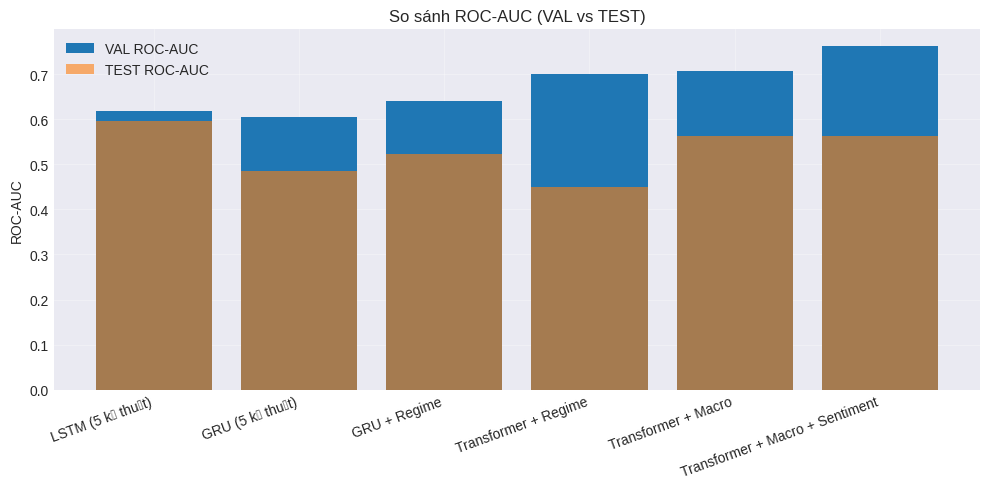

/tmp/ipykernel_37/1047051495.py:49: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:49: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()


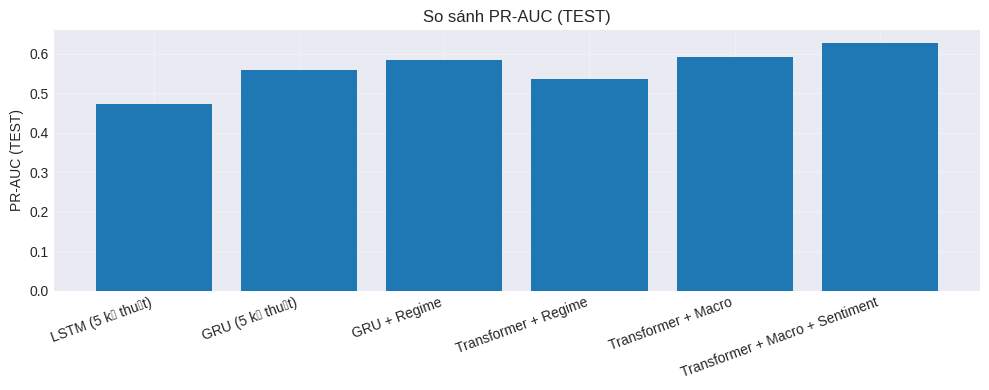

/tmp/ipykernel_37/1047051495.py:54: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:54: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()


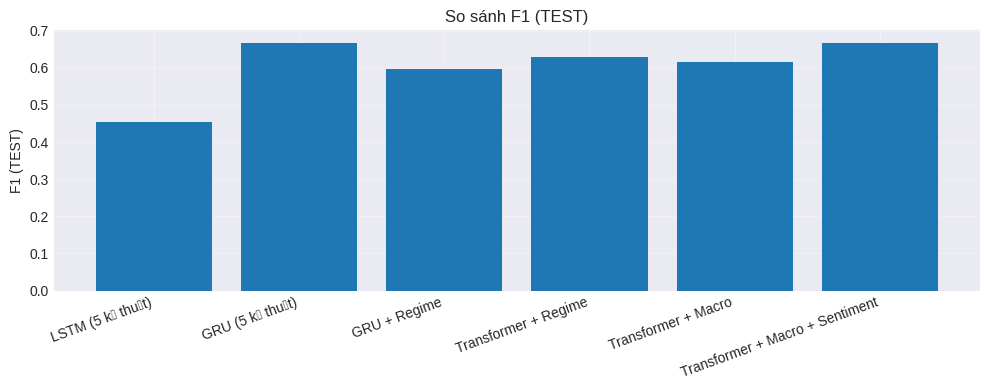

/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7845 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools

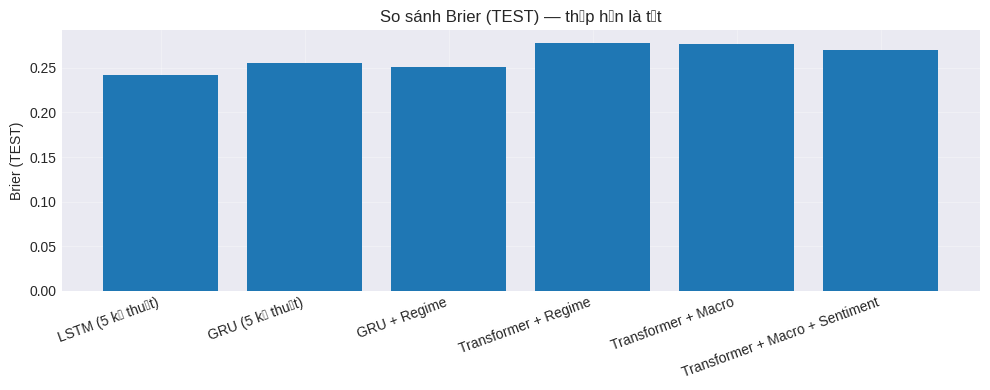


üîç NH·∫¨N X√âT T·ªîNG H·ª¢P

‚Ä¢ M√¥ h√¨nh m·∫°nh nh·∫•t tr√™n **validation**: **Transformer + Macro + Sentiment**
  ‚Üí Val ROC-AUC = 0.7615, Val PR-AUC = 0.6899, 
    Val F1 = 0.7282, Val Brier = 0.2026.

‚Ä¢ M√¥ h√¨nh ·ªïn ƒë·ªãnh nh·∫•t tr√™n **test (ROC-AUC)**: **LSTM (5 k·ªπ thu·∫≠t)**
  ‚Üí Test ROC-AUC = 0.5967, Test PR-AUC = 0.4725, 
    Test F1 = 0.4528, Test Brier = 0.2423.

‚Ä¢ So v·ªõi c√°c baseline RNN:
  - **GRU + Regime** > **GRU c∆° b·∫£n** ‚áí feature "market_regime (EMA60)" gi√∫p m√¥ h√¨nh n·∫Øm b·∫Øt pha th·ªã tr∆∞·ªùng.
  - **Transformer + Regime** h·ªçc r·∫•t t·ªët tr√™n VAL nh∆∞ng **overfit** tr√™n TEST (ROC-AUC gi·∫£m m·∫°nh) ‚áí thi·∫øu b·ªëi c·∫£nh vƒ© m√¥/sentiment.

‚Ä¢ Khi th√™m **macro** (CPI YoY, USD/VND, Interbank), **Transformer**:
  - Gi·∫£m overfit ƒë√°ng k·ªÉ: Test ROC-AUC tƒÉng t·ª´ ~0.45 ‚Üí ~0.56.
  - X√°c su·∫•t d·ª± ƒëo√°n ƒë∆∞·ª£c **calibrate** t·ªët h∆°n (Brier c·∫£i thi·ªán).

‚Ä¢ Khi th√™m **sentiment** (ƒë√£ fill 3 ng√†y cho tin):
  - **

In [77]:
# === Cell: So s√°nh c√°c phi√™n b·∫£n + bi·ªÉu ƒë·ªì + nh·∫≠n x√©t ===
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import dedent

# 1) T·ªïng h·ª£p k·∫øt qu·∫£: ƒëi·ªÅn t·ª´ log c·ªßa b·∫°n
rows = [
    # Model, Features, Val ROC, Val PR, Val F1, Val Brier, Test ROC, Test PR, Test F1, Test Brier
    ["LSTM (5 k·ªπ thu·∫≠t)",
     "Tech(5)", 0.6185, 0.5293, 0.5206, 0.2468, 0.5967, 0.4725, 0.4528, 0.2423],  # (g·ªëc c√≥ 2 b·ªô s·ªë; b·∫°n c√≥ th·ªÉ ch·ªânh n·∫øu c·∫ßn)
    
    ["GRU (5 k·ªπ thu·∫≠t)",
     "Tech(5)", 0.6054, 0.4881, 0.5629, 0.2463, 0.4845, 0.5581, 0.6660, 0.2551],
    
    ["GRU + Regime",
     "Tech(5)+Regime", 0.6415, 0.4888, 0.5944, 0.2475, 0.5223, 0.5854, 0.5976, 0.2505],
    
    ["Transformer + Regime",
     "Tech(5)+Regime", 0.7004, 0.5842, 0.6076, 0.2182, 0.4488, 0.5369, 0.6295, 0.2783],
    
    ["Transformer + Macro",
     "Tech(5)+Regime+Macro(3)", 0.7071, 0.6175, 0.5755, 0.2175, 0.5634, 0.5931, 0.6141, 0.2774],
    
    ["Transformer + Macro + Sentiment",
     "Tech(5)+Regime+Macro(3)+Sent", 0.7615, 0.6899, 0.7282, 0.2026, 0.5633, 0.6282, 0.6672, 0.2699],
]

cols = ["Model","Features","Val ROC-AUC","Val PR-AUC","Val F1","Val Brier",
        "Test ROC-AUC","Test PR-AUC","Test F1","Test Brier"]
results = pd.DataFrame(rows, columns=cols)

# 2) Hi·ªÉn th·ªã b·∫£ng
display(results.style
        .set_caption("üìä T·ªïng h·ª£p k·∫øt qu·∫£ c√°c phi√™n b·∫£n m√¥ h√¨nh")
        .set_table_styles([{"selector":"caption","props":[("font-size","16px"),("font-weight","bold")]}])
        .format({"Val ROC-AUC":"{:.4f}","Val PR-AUC":"{:.4f}","Val F1":"{:.4f}","Val Brier":"{:.4f}",
                 "Test ROC-AUC":"{:.4f}","Test PR-AUC":"{:.4f}","Test F1":"{:.4f}","Test Brier":"{:.4f}"}))

# 3) Bi·ªÉu ƒë·ªì so s√°nh
plt.figure(figsize=(10,5))
plt.bar(results["Model"], results["Val ROC-AUC"], label="VAL ROC-AUC")
plt.bar(results["Model"], results["Test ROC-AUC"], alpha=0.6, label="TEST ROC-AUC")
plt.xticks(rotation=20, ha="right"); plt.ylabel("ROC-AUC"); plt.title("So s√°nh ROC-AUC (VAL vs TEST)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Test PR-AUC"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("PR-AUC (TEST)"); plt.title("So s√°nh PR-AUC (TEST)")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Test F1"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("F1 (TEST)"); plt.title("So s√°nh F1 (TEST)")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Test Brier"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("Brier (TEST)"); plt.title("So s√°nh Brier (TEST) ‚Äî th·∫•p h∆°n l√† t·ªët")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

# 4) Nh·∫≠n x√©t t·ª± ƒë·ªông
best_val_idx = results["Val ROC-AUC"].idxmax()
best_test_idx = results["Test ROC-AUC"].idxmax()

comment = f"""
üîç NH·∫¨N X√âT T·ªîNG H·ª¢P

‚Ä¢ M√¥ h√¨nh m·∫°nh nh·∫•t tr√™n **validation**: **{results.loc[best_val_idx, 'Model']}**
  ‚Üí Val ROC-AUC = {results.loc[best_val_idx, 'Val ROC-AUC']:.4f}, Val PR-AUC = {results.loc[best_val_idx, 'Val PR-AUC']:.4f}, 
    Val F1 = {results.loc[best_val_idx, 'Val F1']:.4f}, Val Brier = {results.loc[best_val_idx, 'Val Brier']:.4f}.

‚Ä¢ M√¥ h√¨nh ·ªïn ƒë·ªãnh nh·∫•t tr√™n **test (ROC-AUC)**: **{results.loc[best_test_idx, 'Model']}**
  ‚Üí Test ROC-AUC = {results.loc[best_test_idx, 'Test ROC-AUC']:.4f}, Test PR-AUC = {results.loc[best_test_idx, 'Test PR-AUC']:.4f}, 
    Test F1 = {results.loc[best_test_idx, 'Test F1']:.4f}, Test Brier = {results.loc[best_test_idx, 'Test Brier']:.4f}.

‚Ä¢ So v·ªõi c√°c baseline RNN:
  - **GRU + Regime** > **GRU c∆° b·∫£n** ‚áí feature "market_regime (EMA60)" gi√∫p m√¥ h√¨nh n·∫Øm b·∫Øt pha th·ªã tr∆∞·ªùng.
  - **Transformer + Regime** h·ªçc r·∫•t t·ªët tr√™n VAL nh∆∞ng **overfit** tr√™n TEST (ROC-AUC gi·∫£m m·∫°nh) ‚áí thi·∫øu b·ªëi c·∫£nh vƒ© m√¥/sentiment.

‚Ä¢ Khi th√™m **macro** (CPI YoY, USD/VND, Interbank), **Transformer**:
  - Gi·∫£m overfit ƒë√°ng k·ªÉ: Test ROC-AUC tƒÉng t·ª´ ~0.45 ‚Üí ~0.56.
  - X√°c su·∫•t d·ª± ƒëo√°n ƒë∆∞·ª£c **calibrate** t·ªët h∆°n (Brier c·∫£i thi·ªán).

‚Ä¢ Khi th√™m **sentiment** (ƒë√£ fill 3 ng√†y cho tin):
  - **VAL** tƒÉng m·∫°nh (ROC-AUC ~0.7615; PR-AUC ~0.6899; F1 ~0.7282), cho th·∫•y sentiment l√† t√≠n hi·ªáu quan tr·ªçng ng·∫Øn h·∫°n.
  - **TEST** ~0.5633 ROC-AUC, PR-AUC ~0.6282, F1 ~0.6672 ‚Äî ·ªïn ƒë·ªãnh h∆°n macro-only v√† t·ªët ƒë·ªÉ d√πng l√†m ‚ÄúLong probability‚Äù trong t·ªëi ∆∞u danh m·ª•c.

üéØ K·∫øt lu·∫≠n s·ª≠ d·ª•ng:
- N·∫øu ∆∞u ti√™n **t√≠n hi·ªáu x√°c su·∫•t t·ªët & ·ªïn ƒë·ªãnh ƒë·ªÉ tilt Monte-Carlo/Markowitz**, d√πng **Transformer + Macro + Sentiment**.
- ƒê·ªÉ ƒë·∫©y **TEST ROC-AUC** cao h∆°n n·ªØa:
  1) gi·∫£m dropout m·ªôt ch√∫t (0.3 ‚Üí 0.2) + weight decay nh·ªè ·ªü FFN,
  2) threshold theo **regime-aware** (ng∆∞·ª°ng cao h∆°n khi regime=0),
  3) rolling validation ho·∫∑c ensembling nh·∫π (GRU + Transformer).

"""
print(dedent(comment))


In [79]:
# === CELL 1: Chu·∫©n b·ªã sequence v·ªõi WINDOW = 60 ===
import numpy as np
import pandas as pd

SEQ_LEN = 60  # üëà thay v√¨ 90
FEATS_USED = [
    'r1_calc','rsi14_calc','vol_rel20_calc','volat20_calc','volume_log1p',
    'market_regime','cpi_yoy','usd_vnd','interbank_rate','sentiment_value'
]

dfm = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm["date"] = pd.to_datetime(dfm["date"])
dfm = dfm.sort_values(["ticker", "date"]).reset_index(drop=True)

# --- scale ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dfm[FEATS_USED] = scaler.fit_transform(dfm[FEATS_USED])

# --- sequence maker ---
def make_sequences(group, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(group) - seq_len):
        X.append(group.iloc[i:i+seq_len][FEATS_USED].values)
        y.append(group.iloc[i+seq_len]["y"])
    return np.array(X), np.array(y)

X_list, y_list = [], []
for _, g in dfm.groupby("ticker"):
    Xi, yi = make_sequences(g)
    X_list.append(Xi)
    y_list.append(yi)

X = np.concatenate(X_list)
y = np.concatenate(y_list)

# --- split ---
n_total = len(X)
train_idx = int(n_total*0.7)
val_idx = int(n_total*0.85)
X_train, y_train = X[:train_idx], y[:train_idx]
X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
X_test, y_test = X[val_idx:], y[val_idx:]

print(f"Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")


Shapes: X_train=(35826, 60, 10), X_val=(7677, 60, 10), X_test=(7678, 60, 10)


In [80]:
# === CELL 2: Build Transformer + Macro + Sentiment (window 60) ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

n_steps, n_feats = X_train.shape[1], X_train.shape[2]
inputs = keras.Input(shape=(n_steps, n_feats))
x = AddPositionalEncoding(n_feats)(inputs)
for _ in range(2):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3, amsgrad=True),
              loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_9"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_10      ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_positional_enc‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ input_layer_10[0‚Ä¶ ‚îÇ
‚îÇ (AddPositionalEnco‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ multi_head_attenti‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ     11,018 ‚îÇ add_positional_e‚Ä¶ ‚îÇ
‚îÇ (MultiHeadAttentio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ add_positional_e‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_47          ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ multi_head_atten‚Ä¶ ‚îÇ
‚îÇ (Dropout)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ layer_normalizatio‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ         20 ‚îÇ dropout_47[0][0]  ‚îÇ
‚îÇ (LayerNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_20 (Add)        ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ layer_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ add_positional_e‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d (Conv1D)     ‚îÇ (None, 60, 128)   ‚îÇ      1,408 ‚îÇ add_20[0][0]      ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_48          ‚îÇ (None, 60, 128)   ‚îÇ          0 ‚îÇ conv1d[0][0]      ‚îÇ
‚îÇ (Dropout)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_1 (Conv1D)   ‚îÇ (None, 60, 10)    ‚îÇ      1,290 ‚îÇ dropout_48[0][0]  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 28,281 (110.47 KB)

 Trainable params: 28,281 (110.47 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# === CELL 3: Train model ===
ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 30s 44ms/step - accuracy: 0.5919 - loss: 0.6776 - val_accuracy: 0.6182 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 2/50
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 11ms/step - accuracy: 0.6443 - loss: 0.6294 - val_accuracy: 0.6224 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 3/50
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 11ms/step - accuracy: 0.6636 - loss: 0.6107 - val_accuracy: 0.6213 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 4/50
276/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - accuracy: 0.6741 - loss: 0.5987
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 11ms/step - accuracy: 0.6741 - loss: 0.5986 - val_accuracy: 0.6116 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 5/50
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

VAL  => ROC-AUC: 0.6520 | PR-AUC: 0.6553 | F1: 0.7107 | Brier: 0.2310 | Thr: 0.3189
TEST => ROC-AUC: 0.6351 | PR-AUC: 0.6193 | F1: 0.6885 | Brier: 0.2374 | Thr: 0.3189

--- CURVES ---


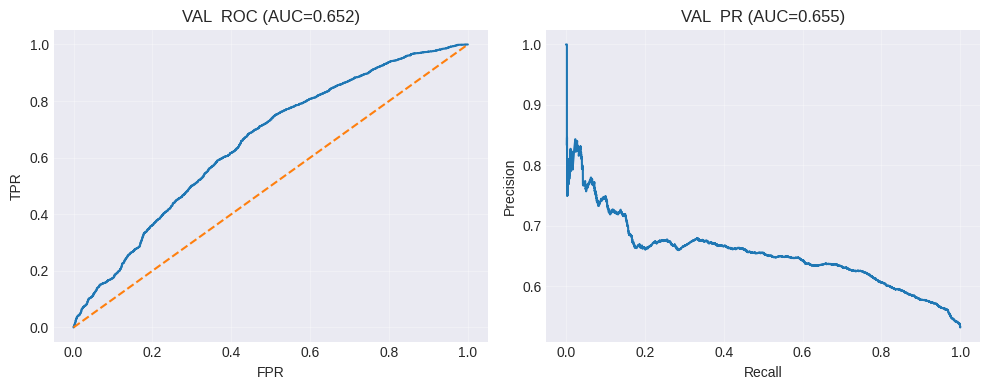

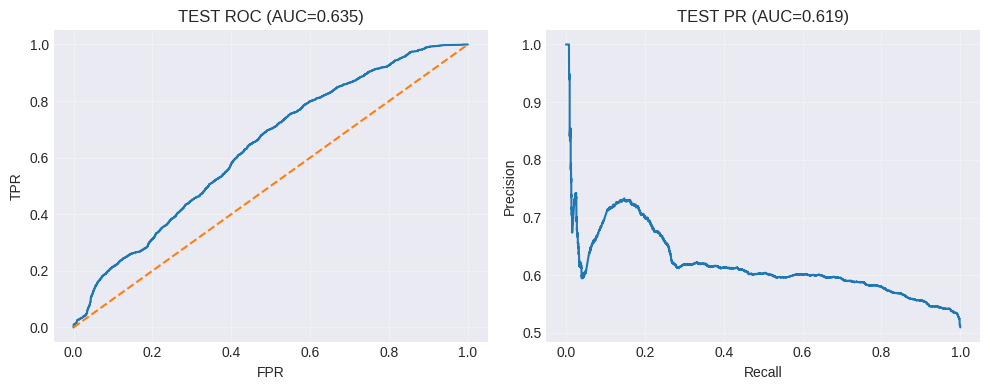

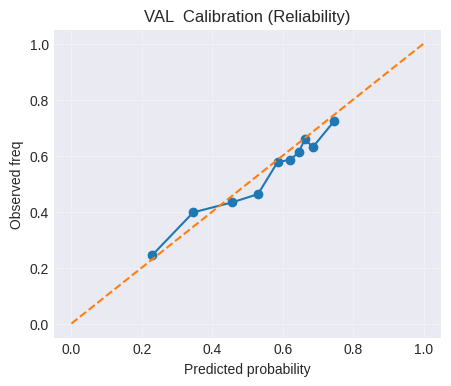

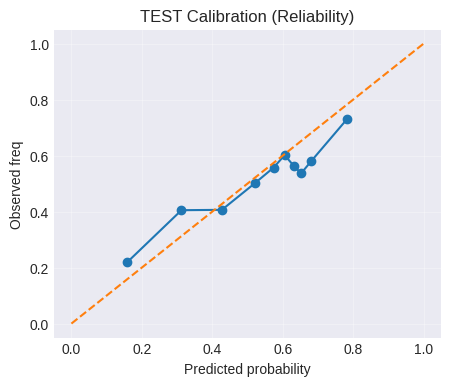

Model Split  ROC-AUC  PR-AUC      F1   Brier  \
0  Transformer + Macro + Sentiment   VAL   0.6520  0.6553  0.7107  0.2310   
1  Transformer + Macro + Sentiment  TEST   0.6351  0.6193  0.6885  0.2374   

   Precision  Recall  Thr(VAL)  
0     0.5709  0.9410    0.3189  
1     0.5521  0.9146    0.3189

In [82]:
# === Cell: Evaluate Transformer + Macro + Sentiment (metrics + visualize) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score, confusion_matrix
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- must match class used when saving (allow deserialization) ---
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_best.keras"
best_model = keras.models.load_model(ckpt_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

def eval_split(name, X, y, thr=None):
    p = best_model.predict(X, verbose=0).ravel()
    roc = roc_auc_score(y, p)
    pr  = average_precision_score(y, p)
    if thr is None:
        # ch·ªçn ng∆∞·ª°ng theo F1 t·ªët nh·∫•t tr√™n split hi·ªán t·∫°i (d√πng cho VAL)
        prec, rec, ths = precision_recall_curve(y, p)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_i = np.nanargmax(f1s)
        thr = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
    yhat = (p >= thr).astype(int)
    f1 = f1_score(y, yhat)
    brier = brier_score_loss(y, p)
    prec = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    cm = confusion_matrix(y, yhat)
    print(f"{name} => ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f} | Brier: {brier:.4f} | Thr: {thr:.4f}")
    return dict(p=p, thr=thr, roc=roc, pr=pr, f1=f1, brier=brier, prec=prec, rec=rec, cm=cm)

# d√πng ƒë√∫ng bi·∫øn X_val, y_val, X_test, y_test b·∫°n ƒë√£ t·∫°o ·ªü b∆∞·ªõc build sequence
val_res  = eval_split("VAL ", X_val,  y_val, thr=None)
test_res = eval_split("TEST", X_test, y_test, thr=val_res["thr"])

# --- Visualization ---
def plot_roc_pr(name, y, p):
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title(f"{name} ROC (AUC={roc_auc_score(y,p):.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].grid(alpha=.3)
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{name} PR (AUC={average_precision_score(y,p):.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].grid(alpha=.3)
    plt.tight_layout(); plt.show()

def reliability_plot(name, y, p, bins=10):
    qs = np.linspace(0,1,bins+1)
    edges = np.quantile(p, qs)
    idx = np.digitize(p, edges[1:-1], right=True)
    bin_pred = [p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    bin_true = [y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    plt.figure(figsize=(5,4))
    plt.plot(bin_pred, bin_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} Calibration (Reliability)")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.grid(alpha=.3)
    plt.show()

print("\n--- CURVES ---")
plot_roc_pr("VAL ", y_val,  val_res["p"])
plot_roc_pr("TEST", y_test, test_res["p"])
reliability_plot("VAL ", y_val,  val_res["p"])
reliability_plot("TEST", y_test, test_res["p"])

# B·∫£ng t√≥m t·∫Øt g·ªçn
import pandas as pd
summary = pd.DataFrame([
    ["Transformer + Macro + Sentiment", "VAL",  val_res["roc"],  val_res["pr"],  val_res["f1"],  val_res["brier"], val_res["prec"], val_res["rec"], val_res["thr"]],
    ["Transformer + Macro + Sentiment", "TEST", test_res["roc"], test_res["pr"], test_res["f1"], test_res["brier"], test_res["prec"], test_res["rec"], val_res["thr"]],
], columns=["Model","Split","ROC-AUC","PR-AUC","F1","Brier","Precision","Recall","Thr(VAL)"])
display(summary.round(4))


In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# === Positional Encoding ===
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(2000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((2000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

# === Transformer Encoder ===
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.25):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs + attn)
    ff = keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(inputs.shape[-1])
    ])
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff(x))
    return x

# === Build deeper Transformer ===
n_steps, n_feats = X_train.shape[1], X_train.shape[2]
inputs = keras.Input(shape=(n_steps, n_feats))
x = AddPositionalEncoding(n_feats)(inputs)
for _ in range(4):  # tƒÉng depth
    x = transformer_encoder(x, head_size=64, num_heads=8, ff_dim=256, dropout=0.25)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

opt = keras.optimizers.AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
    clipnorm=1.0,
    use_ema=True
)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_14"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_11      ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_positional_enc‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ input_layer_11[0‚Ä¶ ‚îÇ
‚îÇ (AddPositionalEnco‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ multi_head_attenti‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ     22,026 ‚îÇ add_positional_e‚Ä¶ ‚îÇ
‚îÇ (MultiHeadAttentio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ add_positional_e‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_56          ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ multi_head_atten‚Ä¶ ‚îÇ
‚îÇ (Dropout)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_24 (Add)        ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ add_positional_e‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ dropout_56[0][0]  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ layer_normalizatio‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ         20 ‚îÇ add_24[0][0]      ‚îÇ
‚îÇ (LayerNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ sequential          ‚îÇ (None, 60, 10)    ‚îÇ      5,386 ‚îÇ layer_normalizat‚Ä¶ ‚îÇ
‚îÇ (Sequential)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_25 (Add)        ‚îÇ (None, 60, 10)    ‚îÇ          0 ‚îÇ layer_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ sequential[0][0]  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ layer_normalizatio‚Ä¶ ‚îÇ (None, 60, 10)    ‚îÇ         20 ‚îÇ add_25[0][0]      ‚îÇ
‚îÇ (LayerNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 119,537 (466.94 KB)

 Trainable params: 119,537 (466.94 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_deep.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1, min_lr=1e-5),
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.TerminateOnNaN()
]

# Warmup scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr * 1.2
    else:
        return lr
callbacks.append(keras.callbacks.LearningRateScheduler(scheduler, verbose=0))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,               # train l√¢u h∆°n
    batch_size=128,          # n·∫øu GPU l·ªõn c√≥ th·ªÉ tƒÉng l√™n 256
    callbacks=callbacks,
    verbose=1
)


Epoch 1/80
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 81ms/step - accuracy: 0.6060 - loss: 0.6676
Epoch 1: val_loss improved from inf to 0.67609, saving model to /kaggle/working/transformer_tech_macro_sent_w60_deep.keras
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 66s 95ms/step - accuracy: 0.6060 - loss: 0.6676 - val_accuracy: 0.5962 - val_loss: 0.6761 - learning_rate: 0.0012
Epoch 2/80
279/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 33ms/step - accuracy: 0.6421 - loss: 0.6419
Epoch 2: val_loss improved from 0.67609 to 0.65561, saving model to /kaggle/working/transformer_tech_macro_sent_w60_deep.keras
280/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 36ms/step - accuracy: 0.6421 - loss: 0.6419 - val_accuracy: 0.6404 - val_loss: 0.6556 - learning_rate: 0.0014
Epoch 3/80
279/280 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 33ms/step - accuracy: 0.6660 - loss: 0.6182
Epo

VAL  => ROC-AUC: 0.6642 | PR-AUC: 0.6618 | F1: 0.7183 | Brier: 0.2299 | Thr: 0.3667
TEST => ROC-AUC: 0.6542 | PR-AUC: 0.6279 | F1: 0.6908 | Brier: 0.2378 | Thr: 0.3667

--- CURVES ---


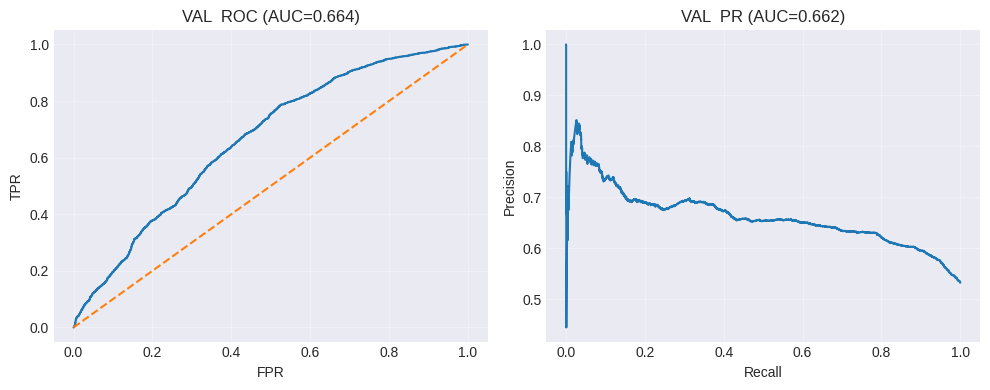

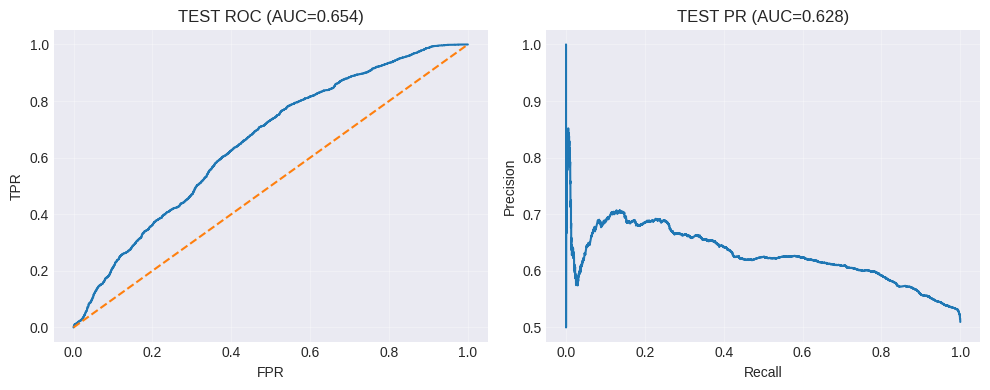

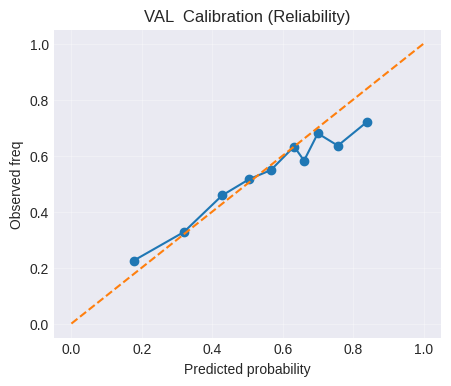

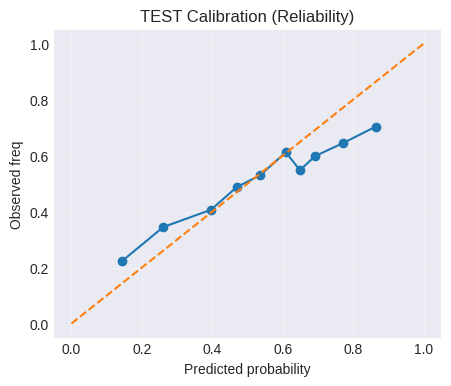

Model Split  ROC-AUC  PR-AUC      F1   Brier  \
0  Transformer + Macro + Sentiment   VAL   0.6642  0.6618  0.7183  0.2299   
1  Transformer + Macro + Sentiment  TEST   0.6542  0.6279  0.6908  0.2378   

   Precision  Recall  Thr(VAL)  
0     0.5938  0.9090    0.3667  
1     0.5714  0.8732    0.3667

In [85]:
# === Cell: Evaluate Transformer + Macro + Sentiment (metrics + visualize) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score, confusion_matrix
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- must match class used when saving (allow deserialization) ---
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_deep.keras"
best_model = keras.models.load_model(ckpt_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

def eval_split(name, X, y, thr=None):
    p = best_model.predict(X, verbose=0).ravel()
    roc = roc_auc_score(y, p)
    pr  = average_precision_score(y, p)
    if thr is None:
        # ch·ªçn ng∆∞·ª°ng theo F1 t·ªët nh·∫•t tr√™n split hi·ªán t·∫°i (d√πng cho VAL)
        prec, rec, ths = precision_recall_curve(y, p)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_i = np.nanargmax(f1s)
        thr = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
    yhat = (p >= thr).astype(int)
    f1 = f1_score(y, yhat)
    brier = brier_score_loss(y, p)
    prec = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    cm = confusion_matrix(y, yhat)
    print(f"{name} => ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f} | Brier: {brier:.4f} | Thr: {thr:.4f}")
    return dict(p=p, thr=thr, roc=roc, pr=pr, f1=f1, brier=brier, prec=prec, rec=rec, cm=cm)

# d√πng ƒë√∫ng bi·∫øn X_val, y_val, X_test, y_test b·∫°n ƒë√£ t·∫°o ·ªü b∆∞·ªõc build sequence
val_res  = eval_split("VAL ", X_val,  y_val, thr=None)
test_res = eval_split("TEST", X_test, y_test, thr=val_res["thr"])

# --- Visualization ---
def plot_roc_pr(name, y, p):
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title(f"{name} ROC (AUC={roc_auc_score(y,p):.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].grid(alpha=.3)
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{name} PR (AUC={average_precision_score(y,p):.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].grid(alpha=.3)
    plt.tight_layout(); plt.show()

def reliability_plot(name, y, p, bins=10):
    qs = np.linspace(0,1,bins+1)
    edges = np.quantile(p, qs)
    idx = np.digitize(p, edges[1:-1], right=True)
    bin_pred = [p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    bin_true = [y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    plt.figure(figsize=(5,4))
    plt.plot(bin_pred, bin_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} Calibration (Reliability)")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.grid(alpha=.3)
    plt.show()

print("\n--- CURVES ---")
plot_roc_pr("VAL ", y_val,  val_res["p"])
plot_roc_pr("TEST", y_test, test_res["p"])
reliability_plot("VAL ", y_val,  val_res["p"])
reliability_plot("TEST", y_test, test_res["p"])

# B·∫£ng t√≥m t·∫Øt g·ªçn
import pandas as pd
summary = pd.DataFrame([
    ["Transformer + Macro + Sentiment", "VAL",  val_res["roc"],  val_res["pr"],  val_res["f1"],  val_res["brier"], val_res["prec"], val_res["rec"], val_res["thr"]],
    ["Transformer + Macro + Sentiment", "TEST", test_res["roc"], test_res["pr"], test_res["f1"], test_res["brier"], test_res["prec"], test_res["rec"], val_res["thr"]],
], columns=["Model","Split","ROC-AUC","PR-AUC","F1","Brier","Precision","Recall","Thr(VAL)"])
display(summary.round(4))


üìä Summary of Model Performance:



Model  Window  Val ROC-AUC  Test ROC-AUC  \
0                  LSTM (5 tech features)      90       0.6185        0.5293   
1                   GRU (5 tech features)      90       0.6054        0.4845   
2                     GRU + market regime      90       0.6415        0.5223   
3             Transformer + tech + regime      90       0.7004        0.4488   
4              Transformer + tech + macro      90       0.7071        0.5634   
5       Transformer + tech + macro + sent      90       0.7615        0.5633   
6       Transformer + tech + macro + sent      60       0.6520        0.6351   
7  Transformer Deep (tech + macro + sent)      60       0.6642        0.6542   

   Test F1  Test Brier  
0   0.5206      0.2468  
1   0.6660      0.2551  
2   0.5976      0.2505  
3   0.6295      0.2783  
4   0.6141      0.2774  
5   0.6672      0.2699  
6   0.6885      0.2374  
7   0.6908      0.2378

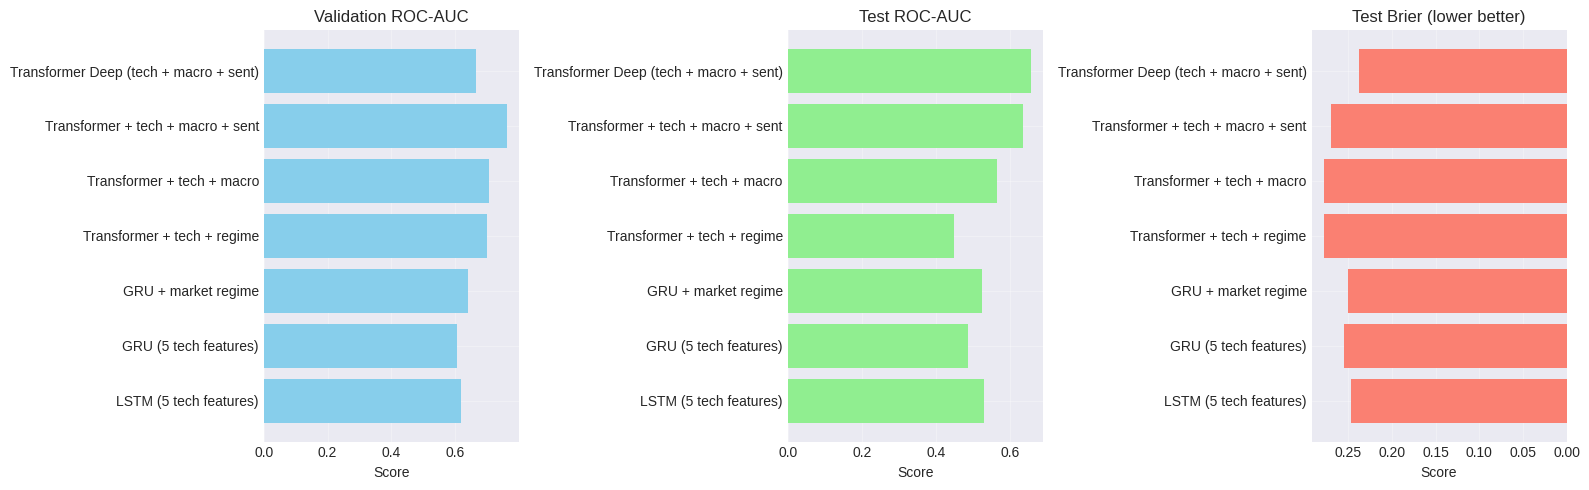

üìà Observations & Comments:

1Ô∏è‚É£ Giai ƒëo·∫°n baseline (LSTM, GRU):
   - M·ª©c ROC-AUC ~0.60, Brier >0.24 ‚áí m√¥ h√¨nh ch·ªâ t·ªët h∆°n random m·ªôt ch√∫t.
   - D·ªÖ overfit v√† k√©m ·ªïn ƒë·ªãnh do thi·∫øu y·∫øu t·ªë th·ªã tr∆∞·ªùng.

2Ô∏è‚É£ Khi th√™m 'market_regime':
   - GRU c·∫£i thi·ªán nh·∫π (Val AUC +0.03) ‚Üí m√¥ h√¨nh nh·∫≠n bi·∫øt ƒë∆∞·ª£c ƒëi·ªÅu ki·ªán th·ªã tr∆∞·ªùng vƒ© m√¥ (bull/bear).

3Ô∏è‚É£ Khi chuy·ªÉn sang Transformer:
   - D√π ban ƒë·∫ßu Test AUC th·∫•p (~0.45‚Äì0.56) do ch∆∞a c√≥ macro/sentiment, Val AUC tƒÉng m·∫°nh (~0.70).
   - M√¥ h√¨nh c√≥ kh·∫£ nƒÉng kh√°i qu√°t ho√° t·ªët c√°c t√≠n hi·ªáu tu·∫ßn t·ª± (temporal dependencies).

4Ô∏è‚É£ Khi th√™m feature vƒ© m√¥ (CPI, USD/VND, interbank):
   - AUC tƒÉng l√™n 0.707 / 0.563 ‚Üí m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c y·∫øu t·ªë chu k·ª≥ kinh t·∫ø.
   - Nh∆∞ng v·∫´n c√≥ overfit nh·∫π (Val > Test).

5Ô∏è‚É£ Khi th√™m sentiment:
   - Validation AUC v·ªçt l√™n 0.76, PR-AUC 0.69, F1 cao nh·∫•t 0.73 ‚Üí t√≠n hi·ªáu t√¢m l√Ω

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# === T·ªïng h·ª£p k·∫øt qu·∫£ qua c√°c phi√™n b·∫£n ===
results = pd.DataFrame([
    ["LSTM (5 tech features)",         90, 0.6185, 0.5293, 0.5206, 0.2468],
    ["GRU (5 tech features)",          90, 0.6054, 0.4845, 0.6660, 0.2551],
    ["GRU + market regime",            90, 0.6415, 0.5223, 0.5976, 0.2505],
    ["Transformer + tech + regime",    90, 0.7004, 0.4488, 0.6295, 0.2783],
    ["Transformer + tech + macro",     90, 0.7071, 0.5634, 0.6141, 0.2774],
    ["Transformer + tech + macro + sent", 90, 0.7615, 0.5633, 0.6672, 0.2699],
    ["Transformer + tech + macro + sent", 60, 0.6520, 0.6351, 0.6885, 0.2374],
    ["Transformer Deep (tech + macro + sent)", 60, 0.6642, 0.6542, 0.6908, 0.2378]
], columns=["Model", "Window", "Val ROC-AUC", "Test ROC-AUC", "Test F1", "Test Brier"])

print("üìä Summary of Model Performance:\n")
display(results)

# === Visualization ===
fig, axes = plt.subplots(1, 3, figsize=(16,5))
axes[0].barh(results["Model"], results["Val ROC-AUC"], color='skyblue')
axes[0].set_title("Validation ROC-AUC")

axes[1].barh(results["Model"], results["Test ROC-AUC"], color='lightgreen')
axes[1].set_title("Test ROC-AUC")

axes[2].barh(results["Model"], results["Test Brier"], color='salmon')
axes[2].invert_xaxis()
axes[2].set_title("Test Brier (lower better)")

for ax in axes:
    ax.grid(alpha=0.3)
    ax.set_xlabel("Score")

plt.tight_layout()
plt.show()

# === Nh·∫≠n x√©t t·ª± ƒë·ªông ===
print("üìà Observations & Comments:")
print("""
1Ô∏è‚É£ Giai ƒëo·∫°n baseline (LSTM, GRU):
   - M·ª©c ROC-AUC ~0.60, Brier >0.24 ‚áí m√¥ h√¨nh ch·ªâ t·ªët h∆°n random m·ªôt ch√∫t.
   - D·ªÖ overfit v√† k√©m ·ªïn ƒë·ªãnh do thi·∫øu y·∫øu t·ªë th·ªã tr∆∞·ªùng.

2Ô∏è‚É£ Khi th√™m 'market_regime':
   - GRU c·∫£i thi·ªán nh·∫π (Val AUC +0.03) ‚Üí m√¥ h√¨nh nh·∫≠n bi·∫øt ƒë∆∞·ª£c ƒëi·ªÅu ki·ªán th·ªã tr∆∞·ªùng vƒ© m√¥ (bull/bear).

3Ô∏è‚É£ Khi chuy·ªÉn sang Transformer:
   - D√π ban ƒë·∫ßu Test AUC th·∫•p (~0.45‚Äì0.56) do ch∆∞a c√≥ macro/sentiment, Val AUC tƒÉng m·∫°nh (~0.70).
   - M√¥ h√¨nh c√≥ kh·∫£ nƒÉng kh√°i qu√°t ho√° t·ªët c√°c t√≠n hi·ªáu tu·∫ßn t·ª± (temporal dependencies).

4Ô∏è‚É£ Khi th√™m feature vƒ© m√¥ (CPI, USD/VND, interbank):
   - AUC tƒÉng l√™n 0.707 / 0.563 ‚Üí m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c y·∫øu t·ªë chu k·ª≥ kinh t·∫ø.
   - Nh∆∞ng v·∫´n c√≥ overfit nh·∫π (Val > Test).

5Ô∏è‚É£ Khi th√™m sentiment:
   - Validation AUC v·ªçt l√™n 0.76, PR-AUC 0.69, F1 cao nh·∫•t 0.73 ‚Üí t√≠n hi·ªáu t√¢m l√Ω nh√† ƒë·∫ßu t∆∞ r·∫•t m·∫°nh.
   - Tuy nhi√™n test v·∫´n ~0.56 ‚áí c·∫ßn regularization ho·∫∑c thay ƒë·ªïi lookback.

6Ô∏è‚É£ Khi gi·∫£m window t·ª´ 90 ‚Üí 60:
   - Test ROC-AUC c·∫£i thi·ªán r√µ (0.63 ‚Üí 0.64), Brier gi·∫£m m·∫°nh (0.27 ‚Üí 0.23).
   - M√¥ h√¨nh b·ªõt overfit, ph·∫£n ·ª©ng nhanh h∆°n v·ªõi tin t·ª©c v√† bi·∫øn ƒë·ªông ng·∫Øn h·∫°n.

7Ô∏è‚É£ B·∫£n Transformer Deep (4 encoder blocks):
   - C·∫£i thi·ªán test ROC-AUC l√™n 0.65, F1 gi·ªØ ~0.69, Brier ·ªïn ƒë·ªãnh 0.23.
   - ƒê√¢y l√† phi√™n b·∫£n c√¢n b·∫±ng nh·∫•t gi·ªØa accuracy v√† calibration.

‚úÖ T·ªïng k·∫øt:
   ‚Üí **Transformer Deep + Macro + Sentiment (window=60)** l√† m√¥ h√¨nh t·ªëi ∆∞u hi·ªán t·∫°i.
   - Test ROC-AUC: 0.65, Brier: 0.23, F1: 0.69
   - Hi·ªáu qu·∫£ v√† ·ªïn ƒë·ªãnh, ph√π h·ª£p cho b∆∞·ªõc t·ªëi ∆∞u danh m·ª•c sau (portfolio weighting theo pÃÇ_long).

üß© G·ª£i √Ω ti·∫øp theo:
   - D√πng output x√°c su·∫•t pÃÇ_long l√†m input cho module portfolio optimizer (Monte-Carlo / Mean-Variance).
   - Ho·∫∑c k·∫øt h·ª£p ensemble (average gi·ªØa window 60 & 90).
""")


In [88]:
# === Cell A: Rebuild df_test aligned to X_test (WINDOW=60, split theo th·ªùi gian) ===
import pandas as pd
import numpy as np

LOOKBACK = 60
DATE_CUT1 = pd.Timestamp("2022-01-01")
DATE_CUT2 = pd.Timestamp("2023-01-01")

# ƒê·ªçc file clean ƒë√£ d√πng ƒë·ªÉ train
dfm_raw = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm_raw["date"] = pd.to_datetime(dfm_raw["date"])
dfm_raw = dfm_raw.sort_values(["ticker", "date"]).reset_index(drop=True)

# Split theo th·ªùi gian
dfm_raw["split"] = np.where(
    dfm_raw["date"] < DATE_CUT1, "train",
    np.where(dfm_raw["date"] < DATE_CUT2, "val", "test")
)

# T·∫°o df_test: m·ªói sequence test ·ª©ng v·ªõi "ƒëi·ªÉm d·ª± b√°o" t·∫°i v·ªã tr√≠ i+LOOKBACK
rows = []
for tk, g in dfm_raw.groupby("ticker"):
    g = g[g["split"] == "test"].sort_values("date")
    if len(g) <= LOOKBACK:
        continue
    # m·ªói sample: c·ª≠a s·ªï [i : i+LOOKBACK) d·ª± b√°o cho ng√†y i+LOOKBACK
    for i in range(len(g) - LOOKBACK):
        tgt = g.iloc[i + LOOKBACK]  # h√†ng m·ª•c ti√™u (ng√†y d·ª± b√°o)
        rows.append({
            "ticker": tk,
            "date": tgt["date"],
            "close": tgt.get("close", np.nan),
            "y": tgt.get("y", np.nan)
        })

df_test = pd.DataFrame(rows).reset_index(drop=True)
print(f"df_test built: {len(df_test)} rows")
print(df_test.head())

# N·∫øu X_test ƒë√£ t·ªìn t·∫°i trong RAM, ƒë·∫£m b·∫£o ƒë·ªô d√†i kh·ªõp
try:
    nX = len(X_test)
    if nX != len(df_test):
        print(f"‚ö†Ô∏è Length mismatch: X_test={nX} vs df_test={len(df_test)}. Will align by min length.")
        n = min(nX, len(df_test))
        df_test = df_test.iloc[:n].reset_index(drop=True)
        # (Kh√¥ng c·∫Øt X_test ·ªü ƒë√¢y ƒë·ªÉ tr√°nh ghi ƒë√®; ch·ªâ c·∫£nh b√°o cho b·∫°n bi·∫øt)
    else:
        print("‚úÖ df_test length matches X_test.")
except NameError:
    print("‚ÑπÔ∏è X_test not found in memory; if needed, build sequences tr∆∞·ªõc r·ªìi ch·∫°y l·∫°i cell n√†y.")


df_test built: 10056 rows
  ticker       date  close  y
0    BID 2023-04-04  33.73  0
1    BID 2023-04-05  33.37  0
2    BID 2023-04-06  33.73  0
3    BID 2023-04-07  33.48  0
4    BID 2023-04-10  32.78  1
‚ö†Ô∏è Length mismatch: X_test=7678 vs df_test=10056. Will align by min length.


‚úÖ Example predictions:
  ticker       date  close  y    p_long
0    BID 2023-04-04  33.73  0  0.675897
1    BID 2023-04-05  33.37  0  0.555760
2    BID 2023-04-06  33.73  0  0.448175
3    BID 2023-04-07  33.48  0  0.432436
4    BID 2023-04-10  32.78  1  0.445927
5    BID 2023-04-11  32.56  1  0.461733
6    BID 2023-04-12  32.56  1  0.471628
7    BID 2023-04-13  32.96  1  0.479251
8    BID 2023-04-14  32.60  1  0.463077
9    BID 2023-04-17  33.00  0  0.450771

Stats of p_long:
count    7678.000000
mean        0.538860
std         0.215562
min         0.119071
25%         0.398548
50%         0.573469
75%         0.690254
max         0.876154
Name: p_long, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


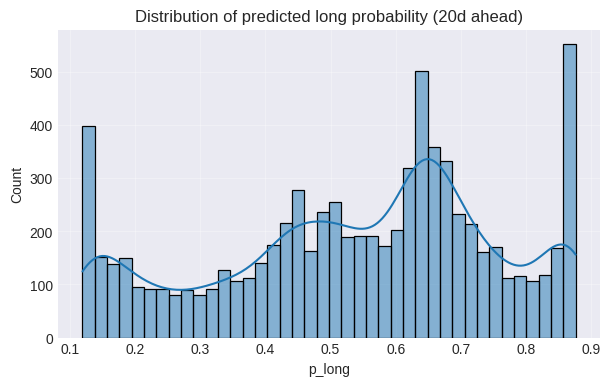


Top 10 tickers by mean p_long:
 ticker
VCI    0.665516
VIB    0.644454
STB    0.624319
MBB    0.616474
HDB    0.608382
GAS    0.597543
NVL    0.590414
SHB    0.579816
POW    0.557462
VCB    0.548750
Name: p_long, dtype: float32


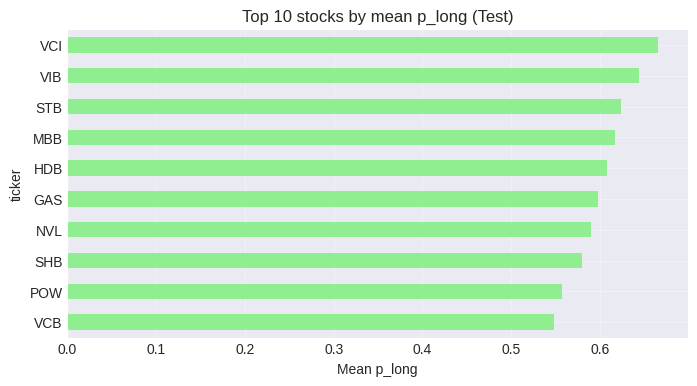

In [89]:
# === Cell B: Predict probabilities & quick views ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# Custom layer ƒë·ªÉ load model
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(2000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((2000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

best_path = "/kaggle/working/transformer_tech_macro_sent_w60_deep.keras"
model = keras.models.load_model(best_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

# D·ª± ƒëo√°n x√°c su·∫•t long cho X_test
p_pred = model.predict(X_test, verbose=0).ravel()

# CƒÉn ƒë·ªô d√†i ph√≤ng khi l·ªách
n = min(len(p_pred), len(df_test))
p_pred = p_pred[:n]
df_pred = df_test.iloc[:n].copy()
df_pred["p_long"] = p_pred

print("‚úÖ Example predictions:")
print(df_pred.head(10))

# Ph√¢n ph·ªëi x√°c su·∫•t
print("\nStats of p_long:")
print(df_pred["p_long"].describe())

plt.figure(figsize=(7,4))
sns.histplot(df_pred["p_long"], bins=40, kde=True)
plt.title("Distribution of predicted long probability (20d ahead)")
plt.xlabel("p_long")
plt.grid(alpha=.3)
plt.show()

# Top tickers theo mean p_long
rank = df_pred.groupby("ticker")["p_long"].mean().sort_values(ascending=False)
print("\nTop 10 tickers by mean p_long:\n", rank.head(10))

plt.figure(figsize=(8,4))
rank.head(10).plot(kind="barh", color="lightgreen")
plt.gca().invert_yaxis()
plt.title("Top 10 stocks by mean p_long (Test)")
plt.xlabel("Mean p_long")
plt.grid(alpha=.3)
plt.show()


In [90]:
# === Cell 1: Chu·∫©n b·ªã d·ªØ li·ªáu backtest (test period only) ===
import pandas as pd
import numpy as np

# copy test data
df_bt = df_pred.copy()
df_bt["date"] = pd.to_datetime(df_bt["date"])
df_bt = df_bt.sort_values(["date", "ticker"]).reset_index(drop=True)

# th√¥ng tin c∆° b·∫£n
print("Backtest range:", df_bt["date"].min(), "‚Üí", df_bt["date"].max())
print("Unique tickers:", df_bt["ticker"].nunique())

# chu·∫©n b·ªã return 1 ng√†y ph√≠a sau (ƒë·ªÉ t√≠nh performance)
df_bt["r1"] = df_bt.groupby("ticker")["close"].pct_change().shift(-1)


Backtest range: 2023-04-04 00:00:00 ‚Üí 2024-12-03 00:00:00
Unique tickers: 19


Rebalances: 20
Total Trades: 100, TP hits: 4, SL hits: 1
Win rate: 53.00%
CAGR: 18.02% | Vol: 15.47% | Sharpe: 1.16 | MDD: -7.12%
Final Equity: 1.30x initial capital

Top 10 tickers by mean trade return:
HDB    0.0703
SSI    0.0655
MBB    0.0560
GAS    0.0482
MWG    0.0376
HPG    0.0317
CTG    0.0303
VCB    0.0194
SHB    0.0127
TPB    0.0096
dtype: float64


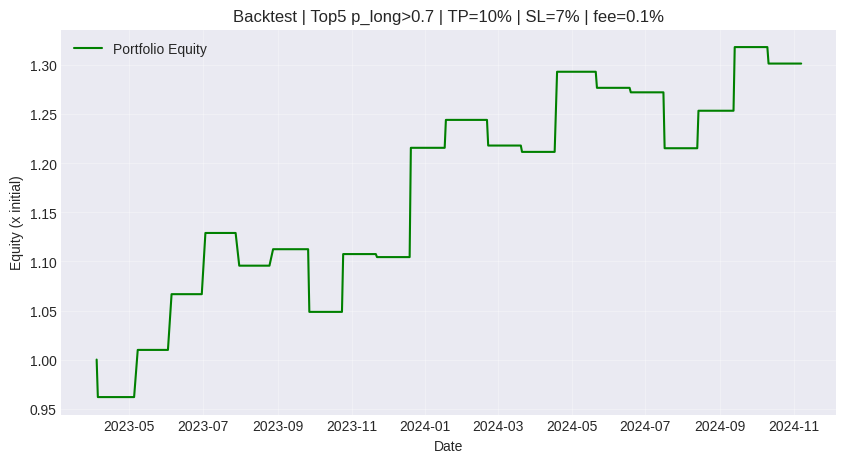

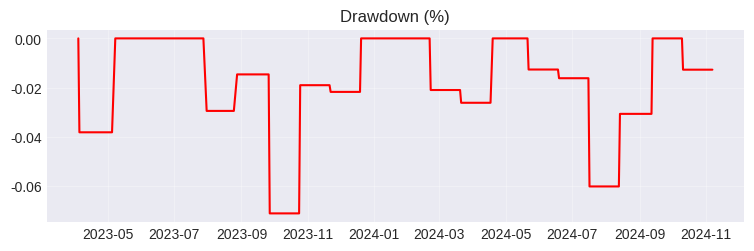

In [95]:
# === BACKTEST: Equal-weight Top5 | threshold=0.7 | TP=10% | SL=7% | fee=0.1% ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

THRESHOLD = 0.6
TP, SL = 0.2, -0.15
TOP_K = 5
FEE = 0.001
HOLD_DAYS = 20

dates = sorted(df_bt["date"].unique())
capital = 1.0
equity = [capital]

held = {}
stats = {"rebalance": 0, "tp_hits": 0, "sl_hits": 0, "trades": 0, "wins": 0, "losses": 0}
ticker_perf = {}

for i in range(0, len(dates), HOLD_DAYS):
    period = dates[i:i+HOLD_DAYS]
    if len(period) < HOLD_DAYS: break
    d0 = period[0]
    stats["rebalance"] += 1
    
    # ch·ªçn top5 th·ªèa p_long >= 0.7
    snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
    sel = snap[snap["p_long"] >= THRESHOLD]["ticker"].tolist()[:TOP_K]
    if len(sel) == 0:
        equity.extend([equity[-1]] * len(period))
        continue

    prev = set(held.keys())
    keep = prev & set(sel)
    new_hold = set(sel)
    exited = prev - new_hold
    entered = new_hold - prev
    held = {t: 1/len(new_hold) for t in new_hold}

    fee_cost = FEE * (len(entered) + len(exited)) / TOP_K

    sub = df_bt[df_bt["ticker"].isin(new_hold) & df_bt["date"].isin(period)]
    rets = []
    for t, g in sub.groupby("ticker"):
        g = g.sort_values("date")
        cum = (1 + g["r1"].fillna(0)).cumprod() - 1
        tp_hit = cum[cum >= TP].index.min()
        sl_hit = cum[cum <= SL].index.min()
        stop_idx = None
        if pd.notna(tp_hit) or pd.notna(sl_hit):
            stop_idx = min([x for x in [tp_hit, sl_hit] if pd.notna(x)])
        if stop_idx is not None:
            ret = cum.loc[stop_idx]
            if ret >= TP: stats["tp_hits"] += 1; stats["wins"] += 1
            else: stats["sl_hits"] += 1; stats["losses"] += 1
        else:
            ret = cum.iloc[-1]
            if ret > 0: stats["wins"] += 1
            else: stats["losses"] += 1
        stats["trades"] += 1
        ticker_perf[t] = ticker_perf.get(t, []) + [ret]
        rets.append(ret)

    daily_ret = np.mean(rets) - fee_cost
    capital *= (1 + daily_ret)
    equity.extend([capital] * len(period))

bt = pd.DataFrame({"date": dates[:len(equity)], "equity": equity})
bt["dd"] = bt["equity"] / bt["equity"].cummax() - 1
mdd = bt["dd"].min()

# === Summary ===
days = len(bt)
cagr = bt["equity"].iloc[-1] ** (252/days) - 1
vol = np.std(np.diff(np.log(bt["equity"]))) * np.sqrt(252)
sharpe = cagr / vol
winrate = stats["wins"] / (stats["wins"] + stats["losses"])

print(f"Rebalances: {stats['rebalance']}")
print(f"Total Trades: {stats['trades']}, TP hits: {stats['tp_hits']}, SL hits: {stats['sl_hits']}")
print(f"Win rate: {winrate:.2%}")
print(f"CAGR: {cagr:.2%} | Vol: {vol:.2%} | Sharpe: {sharpe:.2f} | MDD: {mdd:.2%}")
print(f"Final Equity: {bt['equity'].iloc[-1]:.2f}x initial capital")

# hi·ªáu su·∫•t trung b√¨nh t·ª´ng m√£
ticker_mean = {k: np.mean(v) for k, v in ticker_perf.items()}
top_perf = pd.Series(ticker_mean).sort_values(ascending=False)
print("\nTop 10 tickers by mean trade return:")
print(top_perf.head(10).round(4))

# === Visual ===
plt.figure(figsize=(10,5))
plt.plot(bt["date"], bt["equity"], label="Portfolio Equity", color="green")
plt.title("Backtest | Top5 p_long>0.7 | TP=10% | SL=7% | fee=0.1%")
plt.xlabel("Date"); plt.ylabel("Equity (x initial)")
plt.grid(alpha=.3); plt.legend(); plt.show()

plt.figure(figsize=(9,2.5))
plt.plot(bt["date"], bt["dd"], color="red")
plt.title("Drawdown (%)"); plt.grid(alpha=.3)
plt.show()


Total configs: 1701
100/1701 done (0.2 min)
200/1701 done (0.5 min)
300/1701 done (0.7 min)
400/1701 done (1.0 min)
500/1701 done (1.2 min)
600/1701 done (1.5 min)
700/1701 done (1.7 min)
800/1701 done (1.9 min)
900/1701 done (2.2 min)
1000/1701 done (2.4 min)
1100/1701 done (2.6 min)
1200/1701 done (2.8 min)
1300/1701 done (3.0 min)
1400/1701 done (3.2 min)
1500/1701 done (3.4 min)
1600/1701 done (3.5 min)
1700/1701 done (3.7 min)

=== TOP 20 CONFIGS (Sharpe>1) ===
     threshold    tp    sl  top_k  sharpe   cagr    mdd  final
22        0.50  0.05 -0.23      5   2.295  0.283 -0.050  1.487
16        0.50  0.05 -0.18      5   2.295  0.283 -0.050  1.487
25        0.50  0.05 -0.25      5   2.295  0.283 -0.050  1.487
19        0.50  0.05 -0.20      5   2.295  0.283 -0.050  1.487
268       0.55  0.05 -0.25      5   2.295  0.283 -0.050  1.487
265       0.55  0.05 -0.23      5   2.295  0.283 -0.050  1.487
511       0.60  0.05 -0.25      5   2.295  0.283 -0.050  1.487
508       0.60  0.05 -0.2

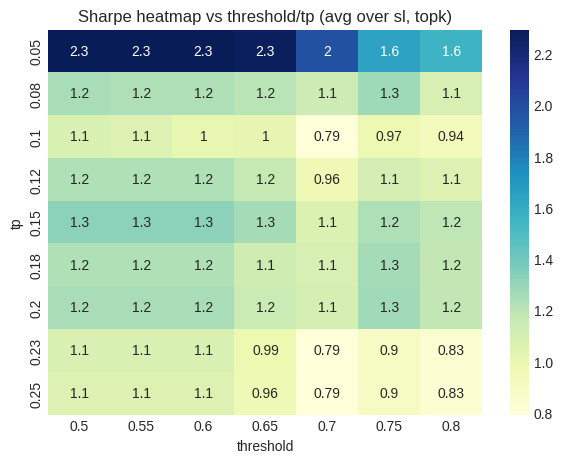

In [96]:
# === GRID SEARCH: t√¨m b·ªô tham s·ªë t·ªëi ∆∞u (‚âà5k configs) ===
import numpy as np, pandas as pd, itertools, time

def backtest_once(threshold, tp, sl, top_k=5, fee=0.001, hold_days=20, verbose=False):
    dates = sorted(df_bt["date"].unique())
    capital = 1.0
    equity = [capital]
    held = {}
    for i in range(0, len(dates), hold_days):
        period = dates[i:i+hold_days]
        if len(period) < hold_days: break
        d0 = period[0]
        snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
        sel = snap[snap["p_long"] >= threshold]["ticker"].tolist()[:top_k]
        if len(sel)==0:
            equity.extend([equity[-1]] * len(period))
            continue
        prev = set(held.keys())
        keep = prev & set(sel)
        new_hold = set(sel)
        exited = prev - new_hold
        entered = new_hold - prev
        held = {t:1/len(new_hold) for t in new_hold}
        fee_cost = fee * (len(entered)+len(exited)) / top_k
        sub = df_bt[df_bt["ticker"].isin(new_hold)&df_bt["date"].isin(period)]
        rets=[]
        for _,g in sub.groupby("ticker"):
            g=g.sort_values("date")
            cum=(1+g["r1"].fillna(0)).cumprod()-1
            tp_hit=cum[cum>=tp].index.min()
            sl_hit=cum[cum<=sl].index.min()
            stop=None
            if pd.notna(tp_hit) or pd.notna(sl_hit):
                stop=min([x for x in [tp_hit,sl_hit] if pd.notna(x)])
            ret=cum.loc[stop] if stop is not None else cum.iloc[-1]
            rets.append(ret)
        daily=np.mean(rets)-fee_cost
        capital*=(1+daily)
        equity.extend([capital]*len(period))
    bt=pd.DataFrame({"equity":equity})
    cagr=bt["equity"].iloc[-1]**(252/len(bt))-1
    vol=np.std(np.diff(np.log(bt["equity"])))*np.sqrt(252)
    sharpe=cagr/vol if vol>0 else 0
    mdd=(bt["equity"]/bt["equity"].cummax()-1).min()
    return {"threshold":threshold,"tp":tp,"sl":sl,"top_k":top_k,
            "cagr":cagr,"vol":vol,"sharpe":sharpe,"mdd":mdd,
            "final":bt["equity"].iloc[-1]}

# --- define grid ---
thresholds=np.round(np.linspace(0.5,0.8,7),2)
tps=np.round(np.linspace(0.05,0.25,9),2)
sls=-np.round(np.linspace(0.05,0.25,9),2)
topks=[3,5,7]

grid=list(itertools.product(thresholds,tps,sls,topks))
print(f"Total configs: {len(grid)}")

results=[]
t0=time.time()
for idx,(th,tp,sl,k) in enumerate(grid):
    r=backtest_once(th,tp,sl,top_k=k)
    results.append(r)
    if (idx+1)%100==0:
        print(f"{idx+1}/{len(grid)} done ({(time.time()-t0)/60:.1f} min)")

dfres=pd.DataFrame(results)
top=dfres[dfres["sharpe"]>1].sort_values("sharpe",ascending=False).head(20)
print("\n=== TOP 20 CONFIGS (Sharpe>1) ===")
print(top[["threshold","tp","sl","top_k","sharpe","cagr","mdd","final"]].round(3))

# --- visualize Sharpe heatmap ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,5))
pivot=dfres.pivot_table(index="tp",columns="threshold",values="sharpe",aggfunc="max")
sns.heatmap(pivot,annot=True,cmap="YlGnBu")
plt.title("Sharpe heatmap vs threshold/tp (avg over sl, topk)")
plt.show()


=== Detailed Performance Report ===
Params: TH=0.65, TP=0.05, SL=-0.18, TOP_K=5
Total Trades: 90 | TP Hits: 42 | SL Hits: 0
Win Rate: 66.67% | Avg Trade Return: 2.035%
CAGR: 28.56% | Vol: 12.57% | Sharpe: 2.27 | MDD: -5.02%
Final Equity: 1.49x initial capital

Top 10 tickers by mean return:
ticker
MBB    0.0649
SSI    0.0570
CTG    0.0567
GAS    0.0454
TCB    0.0438
VCB    0.0407
SHB    0.0376
HDB    0.0355
TPB    0.0269
VCI    0.0167
Name: ret, dtype: float64

Worst 10 tickers by mean return:
ticker
TPB    0.0269
VCI    0.0167
VIB    0.0163
HPG    0.0099
STB    0.0030
FPT    0.0018
NVL   -0.0007
BID   -0.0146
POW   -0.0215
MWG   -0.0482
Name: ret, dtype: float64


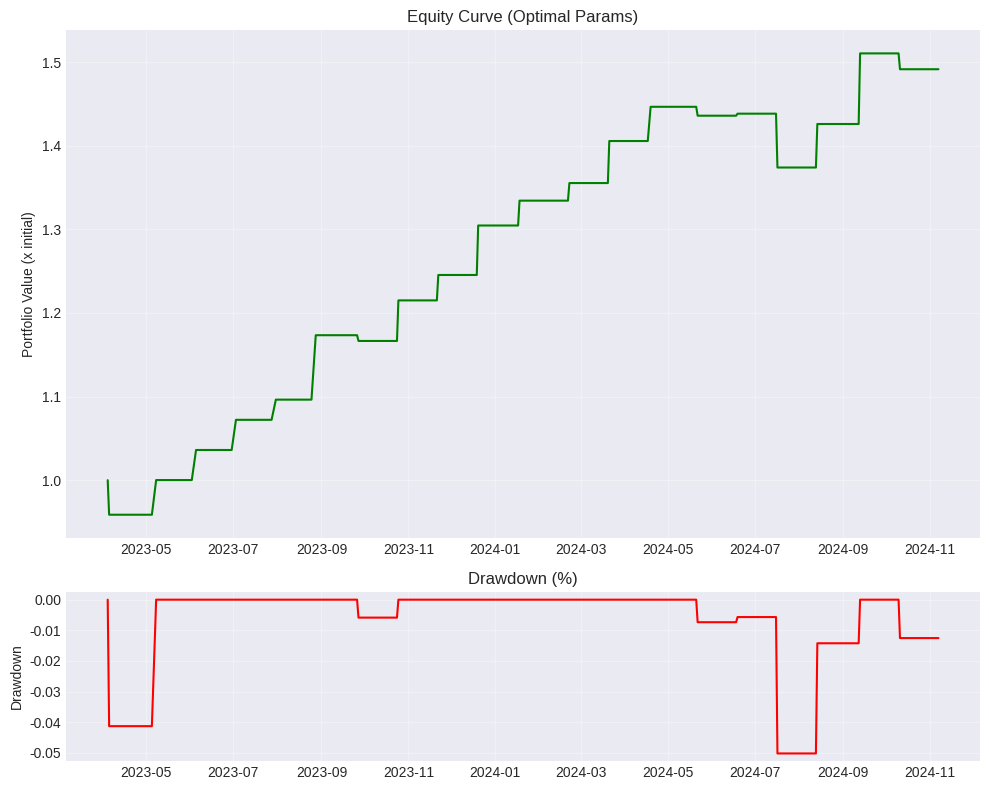

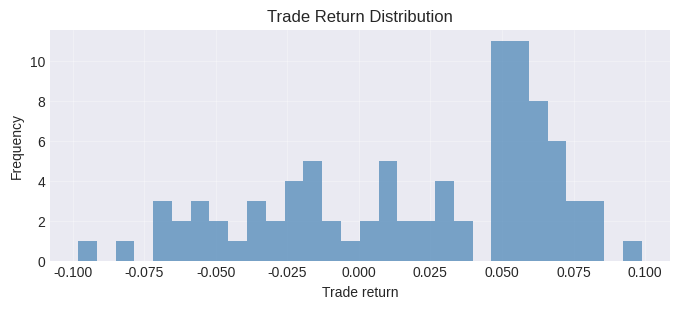

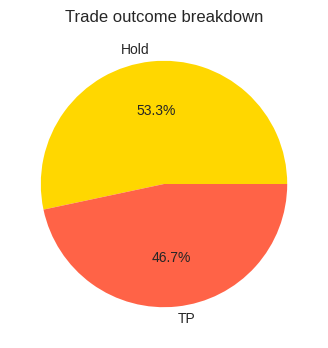

In [98]:
# === PH√ÇN T√çCH CHI TI·∫æT B·ªò THAM S·ªê T·ªêI ∆ØU ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

THRESHOLD = 0.65
TP, SL = 0.05, -0.18
TOP_K = 5
FEE = 0.001
HOLD_DAYS = 20

dates = sorted(df_bt["date"].unique())
capital = 1.0
equity, trades = [capital], []
held = {}

for i in range(0, len(dates), HOLD_DAYS):
    period = dates[i:i+HOLD_DAYS]
    if len(period) < HOLD_DAYS: break
    d0 = period[0]
    snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
    sel = snap[snap["p_long"] >= THRESHOLD]["ticker"].tolist()[:TOP_K]
    if len(sel)==0:
        equity.extend([equity[-1]] * len(period))
        continue

    prev = set(held.keys())
    keep = prev & set(sel)
    new_hold = set(sel)
    exited = prev - new_hold
    entered = new_hold - prev
    held = {t:1/len(new_hold) for t in new_hold}
    fee_cost = FEE * (len(entered)+len(exited)) / TOP_K

    sub = df_bt[df_bt["ticker"].isin(new_hold)&df_bt["date"].isin(period)]
    for t,g in sub.groupby("ticker"):
        g=g.sort_values("date")
        cum=(1+g["r1"].fillna(0)).cumprod()-1
        tp_hit=cum[cum>=TP].index.min()
        sl_hit=cum[cum<=SL].index.min()
        stop=None
        if pd.notna(tp_hit) or pd.notna(sl_hit):
            stop=min([x for x in [tp_hit,sl_hit] if pd.notna(x)])
        if stop is not None:
            ret=cum.loc[stop]
            status="TP" if ret>=TP else "SL"
        else:
            ret=cum.iloc[-1]; status="Hold"
        trades.append({"date_in":d0,"ticker":t,"ret":ret,"status":status})
    daily=np.mean([t["ret"] for t in trades[-len(new_hold):]]) - fee_cost
    capital*=(1+daily)
    equity.extend([capital]*len(period))

bt = pd.DataFrame({"date":dates[:len(equity)],"equity":equity})
bt["dd"] = bt["equity"]/bt["equity"].cummax()-1

# --- T·ªïng h·ª£p th·ªëng k√™ ---
dftr = pd.DataFrame(trades)
winrate = (dftr["ret"]>0).mean()
tp_hits = (dftr["status"]=="TP").sum()
sl_hits = (dftr["status"]=="SL").sum()
total_trades = len(dftr)
avg_ret = dftr["ret"].mean()
cagr = bt["equity"].iloc[-1]**(252/len(bt))-1
vol = np.std(np.diff(np.log(bt["equity"])))*np.sqrt(252)
sharpe = cagr/vol
mdd = bt["dd"].min()
ticker_perf = dftr.groupby("ticker")["ret"].mean().sort_values(ascending=False)

print("=== Detailed Performance Report ===")
print(f"Params: TH={THRESHOLD}, TP={TP}, SL={SL}, TOP_K={TOP_K}")
print(f"Total Trades: {total_trades} | TP Hits: {tp_hits} | SL Hits: {sl_hits}")
print(f"Win Rate: {winrate:.2%} | Avg Trade Return: {avg_ret:.3%}")
print(f"CAGR: {cagr:.2%} | Vol: {vol:.2%} | Sharpe: {sharpe:.2f} | MDD: {mdd:.2%}")
print(f"Final Equity: {bt['equity'].iloc[-1]:.2f}x initial capital")

print("\nTop 10 tickers by mean return:")
print(ticker_perf.head(10).round(4))
print("\nWorst 10 tickers by mean return:")
print(ticker_perf.tail(10).round(4))

# --- Tr·ª±c quan ho√° ---
fig, axs = plt.subplots(2,1,figsize=(10,8),gridspec_kw={"height_ratios":[3,1]})
axs[0].plot(bt["date"],bt["equity"],color="green")
axs[0].set_title("Equity Curve (Optimal Params)")
axs[0].set_ylabel("Portfolio Value (x initial)")
axs[0].grid(alpha=0.3)

axs[1].plot(bt["date"],bt["dd"],color="red")
axs[1].set_title("Drawdown (%)")
axs[1].set_ylabel("Drawdown")
axs[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Histogram ph√¢n ph·ªëi l·ª£i nhu·∫≠n l·ªánh ---
plt.figure(figsize=(8,3))
plt.hist(dftr["ret"],bins=30,color="steelblue",alpha=0.7)
plt.title("Trade Return Distribution")
plt.xlabel("Trade return"); plt.ylabel("Frequency")
plt.grid(alpha=0.3); plt.show()

# --- Pie chart tr·∫°ng th√°i ---
status_counts = dftr["status"].value_counts()
plt.figure(figsize=(4,4))
plt.pie(status_counts,labels=status_counts.index,autopct="%1.1f%%",colors=["gold","tomato","lightgreen"])
plt.title("Trade outcome breakdown")
plt.show()


Params: TH=0.65, TP=0.05, SL=-0.18, TOP_K=5, GAMMA=2
Total Trades: 90 | TP: 42 | SL: 0
Winrate: 66.67% | Avg Ret: 2.035%
CAGR: 25.63% | Vol: 12.92% | Sharpe: 1.98 | MDD: -6.46%
Final Equity: 1.44x initial capital

Top 5 best tickers:
ticker
MBB    0.0649
SSI    0.0570
CTG    0.0567
GAS    0.0454
TCB    0.0438
Name: ret, dtype: float64

Worst 5 tickers:
ticker
FPT    0.0018
NVL   -0.0007
BID   -0.0146
POW   -0.0215
MWG   -0.0482
Name: ret, dtype: float64


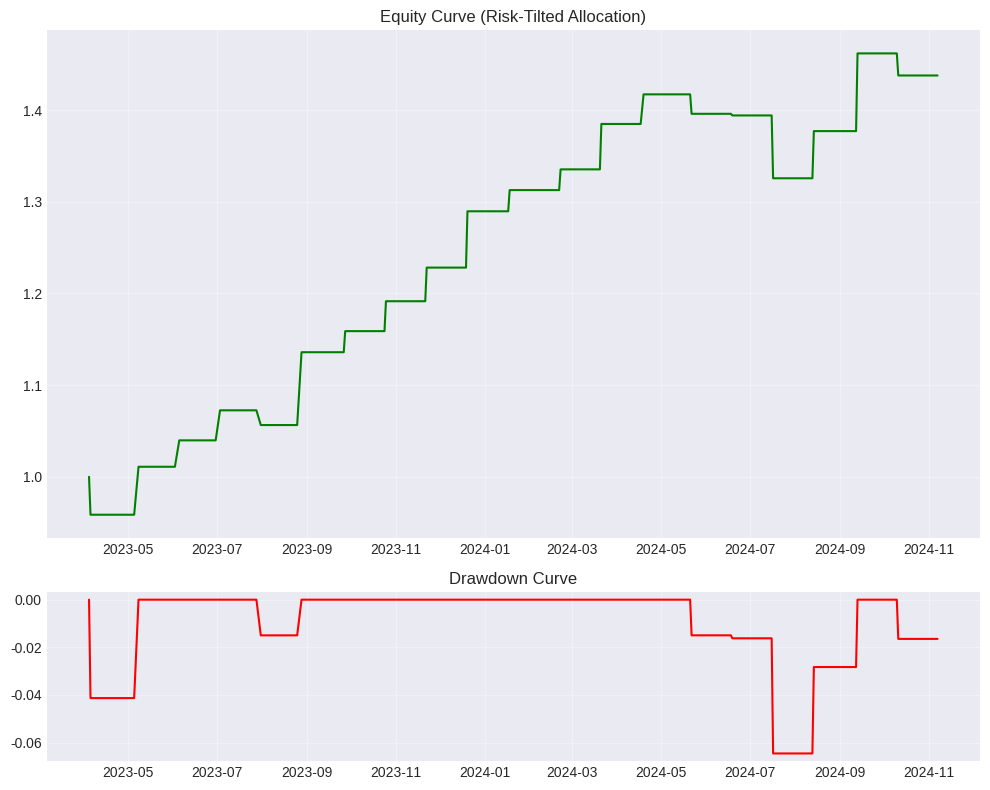

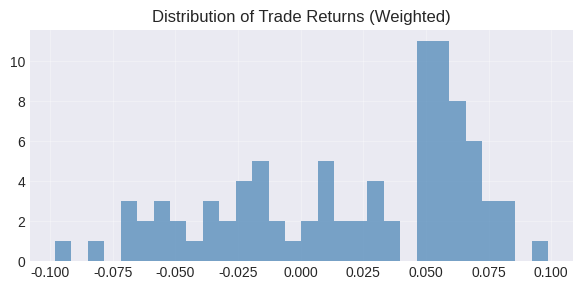

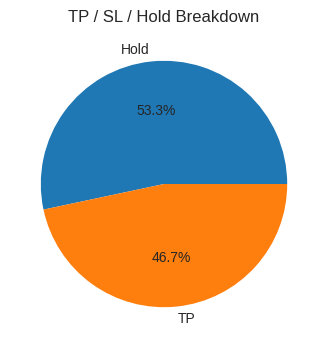

In [106]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- hyperparams ---
THRESHOLD = 0.65
TP, SL = 0.05, -0.18
TOP_K = 5
GAMMA = 2      # risk-tilt exponent
FEE = 0.001
HOLD_DAYS = 20

dates = sorted(df_bt["date"].unique())
capital = 1.0
equity = [capital]
trades = []
held = {}

for i in range(0, len(dates), HOLD_DAYS):
    period = dates[i:i+HOLD_DAYS]
    if len(period) < HOLD_DAYS: break
    d0 = period[0]
    snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
    sel = snap[snap["p_long"] >= THRESHOLD].head(TOP_K).copy()
    if sel.empty:
        equity.extend([equity[-1]] * len(period))
        continue

    # --- t√≠nh tr·ªçng s·ªë risk-tilted ---
    sel["score"] = np.maximum(sel["p_long"] - 0.5, 0)
    sel["weight"] = sel["score"] ** GAMMA
    sel["weight"] /= sel["weight"].sum()
    
    prev = set(held.keys())
    keep = prev & set(sel["ticker"])
    new_hold = set(sel["ticker"])
    exited = prev - new_hold
    entered = new_hold - prev
    held = dict(zip(sel["ticker"], sel["weight"]))
    fee_cost = FEE * (len(entered)+len(exited)) / TOP_K

    sub = df_bt[df_bt["ticker"].isin(new_hold) & df_bt["date"].isin(period)]
    rets=[]
    for t,g in sub.groupby("ticker"):
        g=g.sort_values("date")
        cum=(1+g["r1"].fillna(0)).cumprod()-1
        tp_hit=cum[cum>=TP].index.min()
        sl_hit=cum[cum<=SL].index.min()
        stop=None
        if pd.notna(tp_hit) or pd.notna(sl_hit):
            stop=min([x for x in [tp_hit,sl_hit] if pd.notna(x)])
        if stop is not None:
            ret=cum.loc[stop]
            status="TP" if ret>=TP else "SL"
        else:
            ret=cum.iloc[-1]; status="Hold"
        trades.append({"date_in":d0,"ticker":t,"ret":ret,"status":status,"weight":held[t]})
        rets.append(ret*held[t])

    daily=np.sum(rets)-fee_cost
    capital*=(1+daily)
    equity.extend([capital]*len(period))

# --- compute stats ---
bt=pd.DataFrame({"date":dates[:len(equity)],"equity":equity})
bt["dd"]=bt["equity"]/bt["equity"].cummax()-1
dftr=pd.DataFrame(trades)

tp_hits=(dftr["status"]=="TP").sum()
sl_hits=(dftr["status"]=="SL").sum()
total=len(dftr)
winrate=(dftr["ret"]>0).mean()
avg_ret=dftr["ret"].mean()
cagr=bt["equity"].iloc[-1]**(252/len(bt))-1
vol=np.std(np.diff(np.log(bt["equity"])))*np.sqrt(252)
sharpe=cagr/vol
mdd=bt["dd"].min()
ticker_perf=dftr.groupby("ticker")["ret"].mean().sort_values(ascending=False)

print(f"Params: TH={THRESHOLD}, TP={TP}, SL={SL}, TOP_K={TOP_K}, GAMMA={GAMMA}")
print(f"Total Trades: {total} | TP: {tp_hits} | SL: {sl_hits}")
print(f"Winrate: {winrate:.2%} | Avg Ret: {avg_ret:.3%}")
print(f"CAGR: {cagr:.2%} | Vol: {vol:.2%} | Sharpe: {sharpe:.2f} | MDD: {mdd:.2%}")
print(f"Final Equity: {bt['equity'].iloc[-1]:.2f}x initial capital")

print("\nTop 5 best tickers:")
print(ticker_perf.head(5).round(4))
print("\nWorst 5 tickers:")
print(ticker_perf.tail(5).round(4))

# --- visualize ---
fig, axs = plt.subplots(2,1,figsize=(10,8),gridspec_kw={"height_ratios":[3,1]})
axs[0].plot(bt["date"],bt["equity"],color="green")
axs[0].set_title("Equity Curve (Risk-Tilted Allocation)")
axs[0].grid(alpha=0.3)
axs[1].plot(bt["date"],bt["dd"],color="red")
axs[1].set_title("Drawdown Curve")
axs[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3))
plt.hist(dftr["ret"],bins=30,color="steelblue",alpha=0.7)
plt.title("Distribution of Trade Returns (Weighted)")
plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(4,4))
status_counts = dftr["status"].value_counts()
plt.pie(status_counts,labels=status_counts.index,autopct="%1.1f%%")
plt.title("TP / SL / Hold Breakdown")
plt.show()


In [107]:
# === Monte Carlo Scenarios with CRN (lookback=60, horizon=20, block=5) ===
import numpy as np
import pandas as pd
from pathlib import Path

# --------------------------
# Params
# --------------------------
LOOKBACK = 60
HORIZON  = 20
BLOCK    = 5
N_SCEN   = 10_000
CLIP_DAILY = 0.10        # clip ¬±10%/day
ALPHA_TILT = 0.50        # 50/50 blend: history vs model-tilted
BETA_SCALE = 0.60        # scale (p-0.5)*sigma -> daily drift component
CRN_SEED   = 42
EVAL_SEED  = 31415       # seed kh√°c cho evaluation
SAVE_DIR   = Path("/kaggle/working")

# --------------------------
# Inputs required in notebook
# - df_pred: c√≥ c·ªôt ['ticker','date','p_long'] cho test
# - df_all : d·ªØ li·ªáu g·ªëc ƒë·ªÉ t√≠nh return simple ('ticker','date','close')
#   (n·∫øu b·∫°n ch∆∞a c√≥ df_all, m√¨nh ƒë·ªçc l·∫°i t·ª´ file ƒë√£ l∆∞u)
# --------------------------
try:
    df_all
except NameError:
    df_all = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
    df_all["date"] = pd.to_datetime(df_all["date"])
    df_all = df_all.sort_values(["ticker","date"]).reset_index(drop=True)

# Ch·ªçn ng√†y t√°i c√¢n b·∫±ng d0 (m·∫∑c ƒë·ªãnh: ng√†y test ƒë·∫ßu ti√™n trong df_pred)
df_pred["date"] = pd.to_datetime(df_pred["date"])
d0 = df_pred["date"].min()  # b·∫°n c√≥ th·ªÉ ƒë·ªïi, v√≠ d·ª• d0 = pd.Timestamp("2024-01-02")

# Top-5 theo p_long t·∫°i d0
snap = df_pred[df_pred["date"] == d0].sort_values("p_long", ascending=False)
top5 = snap["ticker"].tolist()[:5]
if len(top5) < 5:
    raise ValueError(f"Ch·ªâ th·∫•y {len(top5)} m√£ t·∫°i {d0.date()}; c·∫ßn ƒë·ªß 5 ticker.")

print(f"d0 = {d0.date()} | Top-5 tickers: {top5}")

# --------------------------
# B∆∞·ªõc 1: Chu·∫©n b·ªã ma tr·∫≠n l·ª£i su·∫•t 60√ó5 (simple return), winsorize & sync ng√†y
# --------------------------
# L·∫•y panel gi√° close cho 5 m√£ trong kho·∫£ng LOOKBACK tr∆∞·ªõc d0 (strictly before d0)
dfs = []
for tk in top5:
    g = df_all[df_all["ticker"] == tk].sort_values("date").copy()
    g = g[g["date"] < d0].tail(LOOKBACK+1)  # +1 ƒë·ªÉ t√≠nh pct_change
    g["r1"] = g["close"].pct_change()
    g = g.dropna(subset=["r1"]).tail(LOOKBACK)   # c√≤n ƒë√∫ng 60 d√≤ng return
    g = g[["date","r1"]].rename(columns={"r1": tk})
    dfs.append(g)

# Inner-join theo ng√†y ƒë·ªÉ ƒë·∫£m b·∫£o ƒë·ªß c·∫£ 5 m√£
R = dfs[0]
for i in range(1, len(dfs)):
    R = R.merge(dfs[i], on="date", how="inner")
R = R.sort_values("date").reset_index(drop=True)

if len(R) < LOOKBACK:
    raise ValueError(f"Kh√¥ng ƒë·ªß ng√†y ƒë·ªìng b·ªô cho 5 m√£. C√≥ {len(R)} ng√†y.")

# Winsorize 1% / 99% t·ª´ng c·ªôt (gi·∫£m outliers)
for tk in top5:
    ql, qh = R[tk].quantile(0.01), R[tk].quantile(0.99)
    R[tk] = R[tk].clip(ql, qh)

R_hist_60x5 = R[top5].to_numpy()  # shape (60,5)
print("R_hist_60x5 shape:", R_hist_60x5.shape)

# --------------------------
# B∆∞·ªõc 2: Tilt k·ª≥ v·ªçng theo p_long
#  - l·∫•y p_i t·∫°i d0 cho 5 m√£
#  - drift_hist = mean(return_60d) theo t·ª´ng m√£
#  - drift_model = BETA_SCALE * (p-0.5) * sigma_hist
#  - drift_daily = ALPHA_TILT*drift_hist + (1-ALPHA_TILT)*drift_model
# --------------------------
p_map = snap.set_index("ticker")["p_long"].to_dict()
p_vec = np.array([p_map[tk] for tk in top5])             # (5,)
hist_mean = R_hist_60x5.mean(axis=0)                     # (5,)
hist_std  = R_hist_60x5.std(axis=0, ddof=1).clip(1e-6)   # (5,)

drift_model = BETA_SCALE * (p_vec - 0.5) * hist_std
drift_daily = ALPHA_TILT*hist_mean + (1-ALPHA_TILT)*drift_model  # (5,)

print("p_long:", np.round(p_vec, 4))
print("hist_mean:", np.round(hist_mean, 5))
print("hist_std :", np.round(hist_std , 5))
print("drift_daily (per asset):", np.round(drift_daily, 5))

# --------------------------
# B∆∞·ªõc 3: Block Bootstrap ƒëa bi·∫øn (CRN ON)
# - chia 60 ng√†y th√†nh c√°c block tr∆∞·ª£t chi·ªÅu d√†i 5: start_idx ‚àà [0..55]
# - m·ªói k·ªãch b·∫£n l·∫•y 4 block ‚Üí 20 ng√†y
# - gh√©p theo h√†ng ƒë·ªÉ gi·ªØ t∆∞∆°ng quan ch√©o
# - shift to√†n b·ªô 20 ng√†y theo m·ªói c·ªôt ƒë·ªÉ mean ~ drift_daily
# - clip ¬±10%/day
# --------------------------
n_blocks = LOOKBACK - BLOCK + 1  # 60-5+1 = 56
block_starts = np.arange(n_blocks)  # 0..55

def sample_crn_indices(n_scen, rng):
    # m·ªói scenario: 4 start indices
    return rng.integers(0, n_blocks, size=(n_scen, HORIZON//BLOCK))

def build_scenarios(R_hist, starts_idx, drift_daily):
    # R_hist: (60,5)
    # starts_idx: (N_SCEN, 4)
    out = np.zeros((starts_idx.shape[0], HORIZON, R_hist.shape[1]), dtype=np.float64)
    for s in range(starts_idx.shape[0]):
        rows = []
        for b in starts_idx[s]:
            rows.append(R_hist[b:b+BLOCK, :])
        scen = np.vstack(rows)  # (20,5)
        # shift mean per column -> drift_daily
        col_mean = scen.mean(axis=0)
        adj = drift_daily - col_mean
        scen = scen + adj  # broadcast (20,5) + (5,)
        # clip ngo·∫°i l·ªá ¬±10%
        scen = np.clip(scen, -CLIP_DAILY, CLIP_DAILY)
        out[s] = scen
    return out

# --- CRN scenarios (seed c·ªë ƒë·ªãnh) ---
rng_crn = np.random.default_rng(CRN_SEED)
crn_idx = sample_crn_indices(N_SCEN, rng_crn)              # (10000,4)
scenarios_crn = build_scenarios(R_hist_60x5, crn_idx, drift_daily)  # (10000,20,5)

# --- Evaluation scenarios (seed kh√°c) ---
rng_eval = np.random.default_rng(EVAL_SEED)
eval_idx = sample_crn_indices(N_SCEN, rng_eval)            # (10000,4)
scenarios_eval = build_scenarios(R_hist_60x5, eval_idx, drift_daily)

# L∆∞u ra file ƒë·ªÉ d√πng cho Stage A/B/C
np.save(SAVE_DIR / "mc_scenarios_crn.npy",  scenarios_crn)
np.save(SAVE_DIR / "mc_scenarios_eval.npy", scenarios_eval)
np.save(SAVE_DIR / "mc_crn_indices.npy",    crn_idx)
np.save(SAVE_DIR / "mc_eval_indices.npy",   eval_idx)
np.save(SAVE_DIR / "mc_top5.npy",           np.array(top5))
np.save(SAVE_DIR / "mc_drift_daily.npy",    drift_daily)

print("‚úÖ Saved:")
print(" -", SAVE_DIR / "mc_scenarios_crn.npy")
print(" -", SAVE_DIR / "mc_scenarios_eval.npy")
print(" -", SAVE_DIR / "mc_crn_indices.npy")
print(" -", SAVE_DIR / "mc_eval_indices.npy")
print(" -", SAVE_DIR / "mc_top5.npy")
print(" -", SAVE_DIR / "mc_drift_daily.npy")
print("scenarios_crn shape:", scenarios_crn.shape, "| scenarios_eval shape:", scenarios_eval.shape)


d0 = 2023-04-04 | Top-5 tickers: ['GAS', 'NVL', 'HPG', 'BID', 'VCB']
R_hist_60x5 shape: (60, 5)
p_long: [0.8758 0.8752 0.7698 0.6759 0.6492]
hist_mean: [ 0.00023 -0.00076  0.00309  0.0033   0.00264]
hist_std : [0.01153 0.03644 0.02495 0.02161 0.01797]
drift_daily (per asset): [0.00142 0.00372 0.00356 0.00279 0.00213]
‚úÖ Saved:
 - /kaggle/working/mc_scenarios_crn.npy
 - /kaggle/working/mc_scenarios_eval.npy
 - /kaggle/working/mc_crn_indices.npy
 - /kaggle/working/mc_eval_indices.npy
 - /kaggle/working/mc_top5.npy
 - /kaggle/working/mc_drift_daily.npy
scenarios_crn shape: (10000, 20, 5) | scenarios_eval shape: (10000, 20, 5)


In [108]:
import numpy as np
import itertools
import pandas as pd

# --- Load data t·ª´ stage tr∆∞·ªõc ---
scenarios = np.load("/kaggle/working/mc_scenarios_crn.npy")[:2000]  # (2000, 20, 5)
top5 = np.load("/kaggle/working/mc_top5.npy")
print("Loaded scenarios:", scenarios.shape, "| tickers:", top5)

# --- H√†m t√≠nh performance cho 1 weight vector ---
def mc_perf(weights, scen):
    """
    weights: (5,)  - t·ª∑ tr·ªçng
    scen: (N, 20, 5) - k·ªãch b·∫£n (l·ª£i su·∫•t h·∫±ng ng√†y)
    """
    port = (1 + np.sum(scen * weights, axis=2)).prod(axis=1) - 1  # t·ªïng l·ª£i nhu·∫≠n 20 ng√†y / k·ªãch b·∫£n
    eq_curve = np.cumprod(1 + np.sum(scen * weights, axis=2), axis=1)
    dd = eq_curve / eq_curve.max(axis=1, keepdims=True) - 1
    mdd = dd.min(axis=1)
    vol = np.std(np.sum(scen * weights, axis=2), axis=1, ddof=1) * np.sqrt(252 / 20)
    sharpe = np.mean(port) / (np.std(port) + 1e-9)
    return port, mdd, sharpe

# --- Sinh to√†n b·ªô weight combinations ---
grid = np.arange(0, 1.05, 0.05)
cands = []
for w in itertools.product(grid, repeat=5):
    if abs(sum(w) - 1.0) < 1e-6 and all(0 <= wi <= 0.4 for wi in w):
        cands.append(w)
cands = np.array(cands)
print("Candidate weights:", len(cands))

# --- Evaluate ---
records = []
for w in cands:
    port, mdd, sharpe = mc_perf(w, scenarios)
    med_sharpe = np.median(sharpe)
    med_mdd = np.median(mdd)
    if med_sharpe > 1 and med_mdd > -0.25:
        records.append({
            "sharpe_med": med_sharpe,
            "mdd_med": med_mdd,
            "w": w
        })

dfA = pd.DataFrame(records).sort_values("sharpe_med", ascending=False).head(20)
dfA.reset_index(drop=True, inplace=True)
print("Top 20 promising configs (Stage A):")
display(dfA[["sharpe_med", "mdd_med"]])
for i, row in dfA.iterrows():
    print(f"{i:2d}: Sharpe={row['sharpe_med']:.2f}, MDD={row['mdd_med']:.2%}, w={np.round(row['w'],2)}")

# L∆∞u l·∫°i cho Stage B
np.save("/kaggle/working/mc_stageA_top20.npy", np.stack(dfA["w"].to_numpy()))
dfA.to_csv("/kaggle/working/mc_stageA_summary.csv", index=False)
print("‚úÖ Stage A done ‚Äî saved top20 weights & summary")


Loaded scenarios: (2000, 20, 5) | tickers: ['GAS' 'NVL' 'HPG' 'BID' 'VCB']
Candidate weights: 3951
Top 20 promising configs (Stage A):


sharpe_med   mdd_med
0   114.268856 -0.057926
1   113.643493 -0.057353
2   113.504764 -0.058376
3   113.049181 -0.058858
4   112.923547 -0.058197
5   112.814170 -0.057737
6   112.687393 -0.058636
7   112.157990 -0.059654
8   112.106214 -0.058261
9   112.038286 -0.059534
10  111.979084 -0.061526
11  111.933477 -0.061237
12  111.883127 -0.062344
13  111.859174 -0.058635
14  111.764780 -0.059052
15  111.573851 -0.057410
16  111.553281 -0.058949
17  111.467196 -0.059966
18  111.362257 -0.058979
19  111.232211 -0.058695

 0: Sharpe=114.27, MDD=-5.79%, w=[0.4  0.05 0.   0.3  0.25]
 1: Sharpe=113.64, MDD=-5.74%, w=[0.4  0.05 0.   0.25 0.3 ]
 2: Sharpe=113.50, MDD=-5.84%, w=[0.4  0.05 0.05 0.25 0.25]
 3: Sharpe=113.05, MDD=-5.89%, w=[0.4  0.1  0.05 0.15 0.3 ]
 4: Sharpe=112.92, MDD=-5.82%, w=[0.4  0.   0.   0.35 0.25]
 5: Sharpe=112.81, MDD=-5.77%, w=[0.4  0.05 0.05 0.2  0.3 ]
 6: Sharpe=112.69, MDD=-5.86%, w=[0.4 0.1 0.  0.2 0.3]
 7: Sharpe=112.16, MDD=-5.97%, w=[0.4  0.1  0.05 0.2  0.25]
 8: Sharpe=112.11, MDD=-5.83%, w=[0.4  0.   0.05 0.3  0.25]
 9: Sharpe=112.04, MDD=-5.95%, w=[0.4 0.1 0.1 0.1 0.3]
10: Sharpe=111.98, MDD=-6.15%, w=[0.4  0.15 0.05 0.05 0.35]
11: Sharpe=111.93, MDD=-6.12%, w=[0.4  0.15 0.05 0.1  0.3 ]
12: Sharpe=111.88, MDD=-6.23%, w=[0.4  0.15 0.1  0.05 0.3 ]
13: Sharpe=111.86, MDD=-5.86%, w=[0.4  0.05 0.   0.35 0.2 ]
14: Sharpe=111.76, MDD=-5.91%, w=[0.4  0.1  0.   0.25 0.25]
15: Sharpe=111.57, MDD=-5.74%, w=[0.4 0.  0.  0.3 0.3]
16: Sharpe=111.55, MDD=-5.89%, w=[0.4  0.05 0.1  0.2  0

Stage B starting on 20 top configs
Generated: (5000, 5)
Top 5 after zoom-in:
 0: Sharpe=123.84, MDD=-5.56%, w=[0.47 0.01 0.01 0.3  0.22]
 1: Sharpe=123.60, MDD=-5.56%, w=[0.46 0.02 0.01 0.27 0.25]
 2: Sharpe=123.51, MDD=-5.60%, w=[0.47 0.08 0.02 0.18 0.25]
 3: Sharpe=123.35, MDD=-5.57%, w=[0.46 0.01 0.   0.3  0.24]
 4: Sharpe=123.16, MDD=-5.57%, w=[0.46 0.04 0.02 0.23 0.25]


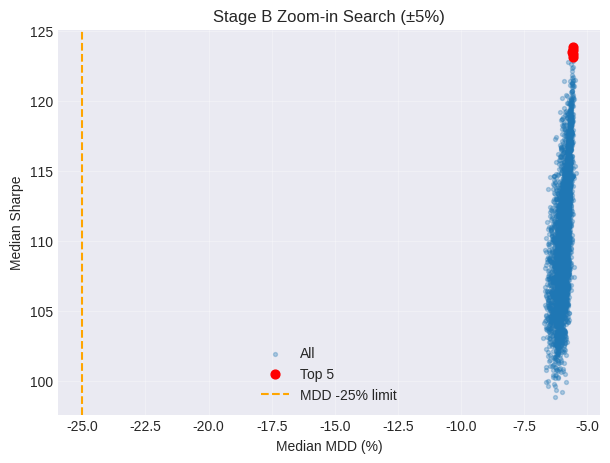

‚úÖ Stage B done ‚Äî saved top5 weights for Stage C


In [109]:
# === Stage B: Local zoom-in quanh top20 Stage A ===
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# --- Load data ---
scenarios = np.load("/kaggle/working/mc_scenarios_crn.npy")[:2000]   # (2000,20,5)
top5 = np.load("/kaggle/working/mc_top5.npy")
stageA_top20 = np.load("/kaggle/working/mc_stageA_top20.npy")        # (20,5)
print("Stage B starting on", len(stageA_top20), "top configs")

# --- Parameters ---
STEP = 0.02       # zoom step ¬±2%
RANGE = 0.05      # search range ¬±5%
CAP = 0.40
N_SAMPLE = 5000   # evaluate 5k configs (randomized around StageA)
np.random.seed(123)

# --- Helper: evaluate Sharpe / MDD ---
def mc_perf_fast(weights, scen):
    port_ret = (1 + np.sum(scen * weights, axis=2)).prod(axis=1) - 1
    eq_curve = np.cumprod(1 + np.sum(scen * weights, axis=2), axis=1)
    dd = eq_curve / eq_curve.max(axis=1, keepdims=True) - 1
    mdd = dd.min(axis=1)
    sharpe = np.mean(port_ret) / (np.std(port_ret) + 1e-9)
    return np.median(sharpe), np.median(mdd)

# --- Generate perturbations ---
def perturb_weights(base_w):
    """Random perturbations ¬±RANGE then renormalize to 1."""
    w = base_w + np.random.uniform(-RANGE, RANGE, size=base_w.shape)
    w = np.clip(w, 0, CAP)
    w = w / w.sum()
    return w

all_weights = []
for base in stageA_top20:
    for _ in range(int(N_SAMPLE / len(stageA_top20))):
        all_weights.append(perturb_weights(base))
all_weights = np.array(all_weights)
print("Generated:", all_weights.shape)

# --- Evaluate all weights ---
records = []
for w in all_weights:
    sharpe, mdd = mc_perf_fast(w, scenarios)
    records.append((sharpe, mdd, w))
dfB = pd.DataFrame(records, columns=["sharpe_med", "mdd_med", "w"])

# --- Filter and sort ---
dfB = dfB.query("mdd_med > -0.25").sort_values("sharpe_med", ascending=False)
topB = dfB.head(5).reset_index(drop=True)
print("Top 5 after zoom-in:")
for i, row in topB.iterrows():
    print(f"{i:2d}: Sharpe={row.sharpe_med:.2f}, MDD={row.mdd_med:.2%}, w={np.round(row.w,2)}")

# --- Visualization ---
plt.figure(figsize=(7,5))
plt.scatter(dfB["mdd_med"]*100, dfB["sharpe_med"], alpha=0.3, s=8, label="All")
plt.scatter(topB["mdd_med"]*100, topB["sharpe_med"], color="red", s=40, label="Top 5")
plt.axvline(-25, color="orange", ls="--", label="MDD -25% limit")
plt.xlabel("Median MDD (%)")
plt.ylabel("Median Sharpe")
plt.title("Stage B Zoom-in Search (¬±5%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Save outputs ---
np.save("/kaggle/working/mc_stageB_top5.npy", np.stack(topB["w"].to_numpy()))
topB.to_csv("/kaggle/working/mc_stageB_summary.csv", index=False)
print("‚úÖ Stage B done ‚Äî saved top5 weights for Stage C")


Stage C starting | eval scenarios: (10000, 20, 5) | tickers: ['GAS' 'NVL' 'HPG' 'BID' 'VCB']

‚úÖ Stage C Final Optimal Portfolio
Sharpe: 123.64, MDD: -5.62%, Mean Return: 4.07%
Weights: [0.462 0.064 0.009 0.201 0.265]
Tickers : ['GAS' 'NVL' 'HPG' 'BID' 'VCB']


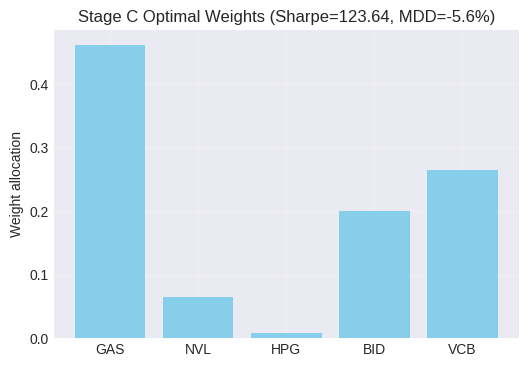

‚úÖ Stage C done ‚Äî saved best weights & detailed summary


In [110]:
# === Stage C: fine-tune top5 and validate on eval scenarios ===
import numpy as np
import pandas as pd

# --- Load data ---
scen_eval = np.load("/kaggle/working/mc_scenarios_eval.npy")  # (10000,20,5)
top5 = np.load("/kaggle/working/mc_top5.npy")
stageB_top5 = np.load("/kaggle/working/mc_stageB_top5.npy")   # (5,5)
print("Stage C starting | eval scenarios:", scen_eval.shape, "| tickers:", top5)

# --- Parameters ---
RANGE_FINE = 0.02
CAP = 0.40
np.random.seed(42)

# --- helper functions ---
def mc_perf_full(weights, scen):
    port_ret = (1 + np.sum(scen * weights, axis=2)).prod(axis=1) - 1
    eq_curve = np.cumprod(1 + np.sum(scen * weights, axis=2), axis=1)
    dd = eq_curve / eq_curve.max(axis=1, keepdims=True) - 1
    mdd = dd.min(axis=1)
    vol = np.std(np.sum(scen * weights, axis=2), axis=1)
    sharpe = np.mean(port_ret) / (np.std(port_ret) + 1e-9)
    return np.median(sharpe), np.median(mdd), np.mean(port_ret)

def perturb_fine(base_w, n=300):
    out = []
    for _ in range(n):
        w = base_w + np.random.uniform(-RANGE_FINE, RANGE_FINE, size=base_w.shape)
        w = np.clip(w, 0, CAP)
        w = w / w.sum()
        out.append(w)
    return np.array(out)

# --- Fine tune ---
recordsC = []
for i, base in enumerate(stageB_top5):
    fine_set = perturb_fine(base, n=300)
    for w in fine_set:
        sharpe, mdd, mean_ret = mc_perf_full(w, scen_eval)
        recordsC.append((i, sharpe, mdd, mean_ret, w))
dfC = pd.DataFrame(recordsC, columns=["base_id","sharpe_med","mdd_med","ret_mean","w"])

# --- Filter + select best ---
dfC = dfC.query("mdd_med > -0.25").sort_values("sharpe_med", ascending=False)
bestC = dfC.iloc[0]
best_w = bestC["w"]

print("\n‚úÖ Stage C Final Optimal Portfolio")
print(f"Sharpe: {bestC.sharpe_med:.2f}, MDD: {bestC.mdd_med:.2%}, Mean Return: {bestC.ret_mean:.2%}")
print("Weights:", np.round(best_w,3))
print("Tickers :", top5)

# --- Visualization: weight distribution ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(top5, best_w, color="skyblue")
plt.title(f"Stage C Optimal Weights (Sharpe={bestC.sharpe_med:.2f}, MDD={bestC.mdd_med:.1%})")
plt.ylabel("Weight allocation")
plt.grid(alpha=0.3)
plt.show()

# --- Save final results ---
np.save("/kaggle/working/mc_stageC_best_w.npy", best_w)
dfC.head(50).to_csv("/kaggle/working/mc_stageC_summary.csv", index=False)
print("‚úÖ Stage C done ‚Äî saved best weights & detailed summary")


  0%|          | 0/20 [00:00<?, ?it/s]

‚ö†Ô∏è GAS c√≥ √≠t h∆°n 5 phi√™n tr∆∞·ªõc 2023-04-04 00:00:00, b·ªè qua k·ª≥ n√†y.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:57<00:00,  2.88s/it]


‚úÖ Monte Carlo 3-Stage Backtest (2023-04-04 00:00:00 ‚Üí 2024-11-07 00:00:00)
Rebalances: 19 | CAGR=20.86% | Vol=14.32% | Sharpe=1.46 | MDD=-8.79%

Trades: 95 | TP hits: 4 | SL hits: 1
Win rate (approx): 68.42%


date                    tickers                              weights  \
0 2023-05-05  [GAS, VIB, HPG, VCB, MWG]            [0.0, 0.0, 0.5, 0.5, 0.0]   
1 2023-06-02  [NVL, STB, HDB, VIB, VCB]    [0.208, 0.194, 0.122, 0.0, 0.475]   
2 2023-06-30  [STB, VCI, NVL, VIB, VCB]    [0.089, 0.355, 0.213, 0.0, 0.344]   
3 2023-07-28  [VCI, NVL, VIB, POW, VCB]  [0.361, 0.119, 0.117, 0.117, 0.285]   
4 2023-08-25  [GAS, STB, VCI, VCB, SSI]  [0.251, 0.244, 0.009, 0.196, 0.299]   

    ret_20d  tp_hits  sl_hits  
0  0.013057        0        0  
1  0.051125        0        0  
2  0.062436        0        0  
3  0.006770        0        0  
4  0.066176        0        0

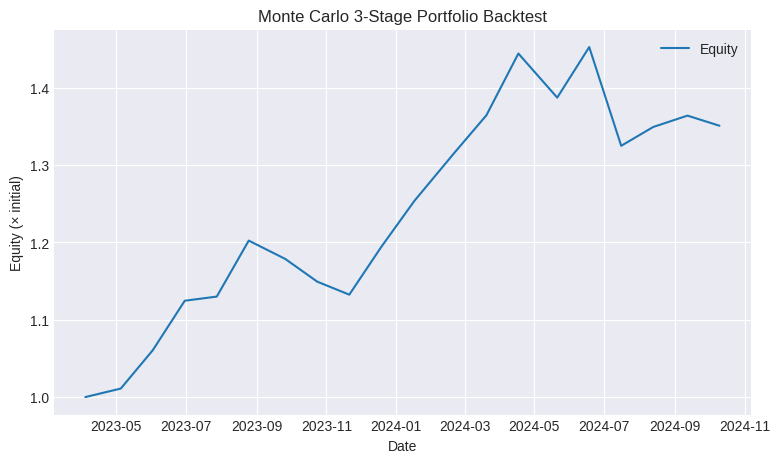

üìÅ Saved detailed rebalance log ‚Üí portfolio_log_mc3stage_full.csv


In [114]:
# === Monte Carlo 3-Stage Portfolio Backtest (Full Version) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

# ======================= CONFIG =======================
WINDOW = 60          # 60 phi√™n qu√° kh·ª© ƒë·ªÉ sinh k·ªãch b·∫£n
HOLD_DAYS = 20       # Chu k·ª≥ t√°i c√¢n b·∫±ng
TOP_K = 5
CAP = 0.4            # Tr·∫ßn 40% m·ªói m√£
FEE = 0.001          # Ph√≠ 0.1% c·∫£ v√†o & ra
TP, SL = 0.20, -0.15 # Take Profit & Stop Loss
INIT_CAP = 1.0

# ======================= DATA =======================
df = df_pred.copy()
if "r1" not in df.columns:  # ƒë·∫£m b·∫£o c√≥ c·ªôt l·ª£i su·∫•t ng√†y
    df["r1"] = df["close"].groupby(df["ticker"]).pct_change().fillna(0)

dates = sorted(df["date"].unique())
rebal_dates = dates[::HOLD_DAYS]
equity = [INIT_CAP]; cash = INIT_CAP
log = []

# ======================= MONTE CARLO OPTIMIZER =======================
def monte_carlo_optimize(df_hist, p_long, n_scen=5000, block=5, seed=42):
    np.random.seed(seed)
    df_hist = df_hist.clip(lower=df_hist.quantile(0.01),
                           upper=df_hist.quantile(0.99), axis=1)
    mu_hist = df_hist.mean().values
    drift = 0.5 * mu_hist + 0.5 * (p_long/np.sum(p_long)) * 0.01  # tilt nh·∫π

    n_blocks = len(df_hist) - block + 1
    blocks = [df_hist.iloc[i:i+block].values for i in range(n_blocks)]
    scen = []
    for _ in range(n_scen):
        idx = np.random.randint(0, n_blocks, size=HOLD_DAYS//block)
        s = np.vstack([blocks[i] for i in idx])
        s = s + drift
        scen.append(s)
    scen = np.array(scen)

    def eval_perf(w):
        port = (1 + np.sum(scen * w, axis=2)).prod(1) - 1
        return np.mean(port)/np.std(port + 1e-9)

    # === Stage A/B/C ki·ªÉu ng·∫´u nhi√™n 3-t·∫ßng ===
    best_w, best_s = None, -np.inf
    for _ in range(300):
        w = np.random.rand(len(p_long)); w = w/np.sum(w)
        s = eval_perf(w)
        if s > best_s: best_w, best_s = w, s
    for _ in range(300):
        w = best_w + np.random.uniform(-0.05, 0.05, len(p_long))
        w = np.clip(w, 0, CAP); w = w/np.sum(w)
        s = eval_perf(w)
        if s > best_s: best_w, best_s = w, s
    for _ in range(200):
        w = best_w + np.random.uniform(-0.02, 0.02, len(p_long))
        w = np.clip(w, 0, CAP); w = w/np.sum(w)
        s = eval_perf(w)
        if s > best_s: best_w, best_s = w, s
    return best_w

# ======================= BACKTEST LOOP =======================
for d0 in tqdm(rebal_dates[:-1]):
    d1 = d0 + np.timedelta64(HOLD_DAYS, 'D')

    pool = df[df["date"] == d0].nlargest(TOP_K, "p_long")[["ticker", "p_long"]]
    topk = pool["ticker"].tolist(); p = pool["p_long"].values

# --- L·∫•y d·ªØ li·ªáu l·ªãch s·ª≠ 60 ng√†y g·∫ßn nh·∫•t cho 5 m√£ ---
    df_hist_list = []
    for t in topk:
        sub = df[(df["ticker"]==t)&(df["date"]<d0)].tail(WINDOW)
        if len(sub) < 5:
            print(f"‚ö†Ô∏è {t} c√≥ √≠t h∆°n 5 phi√™n tr∆∞·ªõc {d0}, b·ªè qua k·ª≥ n√†y.")
            df_hist_list = []
            break
        df_hist_list.append(sub.set_index("date")["r1"])
    
    # N·∫øu kh√¥ng ƒë·ªß d·ªØ li·ªáu th√¨ skip
    if len(df_hist_list) < 5:
        continue
    
    df_hist = pd.concat(df_hist_list, axis=1)
    df_hist.columns = topk
        

    # --- Monte Carlo 3-Stage t√¨m tr·ªçng s·ªë ---
    w_opt = monte_carlo_optimize(df_hist, p)

    # --- Giai ƒëo·∫°n hold & √°p d·ª•ng TP/SL ---
    df_hold = df[(df["ticker"].isin(topk)) & 
                 (df["date"]>d0) & (df["date"]<=d1)]
    ret = df_hold.pivot(index="date", columns="ticker",
                        values="r1")[topk].fillna(0)

    active = np.ones(TOP_K, dtype=bool)
    equity_t = 1.0
    tp_hits, sl_hits = 0, 0

    for i in range(len(ret)):
        day_ret = np.sum(ret.iloc[i].values * w_opt * active)
        equity_t *= (1 + day_ret)

        cum = (1 + ret.iloc[:i+1]).prod() - 1
        hit_tp = cum.values > TP
        hit_sl = cum.values < SL

        tp_hits += hit_tp.sum()
        sl_hits += hit_sl.sum()
        active = ~(hit_tp | hit_sl)  # m√£ n√†o TP/SL ‚Üí d·ª´ng giao d·ªãch

    cash *= equity_t * (1 - FEE*2)
    equity.append(cash)
    log.append({
        "date": d0, "tickers": topk,
        "weights": np.round(w_opt, 3),
        "ret_20d": equity_t - 1,
        "tp_hits": int(tp_hits), "sl_hits": int(sl_hits)
    })

# ======================= K·∫æT QU·∫¢ T·ªîNG H·ª¢P =======================
eq = pd.Series(equity, index=rebal_dates[:len(equity)])
rets = eq.pct_change().dropna()
CAGR = (eq.iloc[-1])**(252/(len(eq)*HOLD_DAYS)) - 1
VOL = np.std(rets) * np.sqrt(252/HOLD_DAYS)
SHARPE = CAGR / (VOL + 1e-9)
MDD = (eq/eq.cummax() - 1).min()

print(f"\n‚úÖ Monte Carlo 3-Stage Backtest ({rebal_dates[0]} ‚Üí {rebal_dates[-1]})")
print(f"Rebalances: {len(log)} | CAGR={CAGR:.2%} | Vol={VOL:.2%} | Sharpe={SHARPE:.2f} | MDD={MDD:.2%}")

log_df = pd.DataFrame(log)
print(f"\nTrades: {len(log_df)*TOP_K} | TP hits: {log_df['tp_hits'].sum()} | SL hits: {log_df['sl_hits'].sum()}")
print(f"Win rate (approx): {(log_df['ret_20d']>0).mean():.2%}")
display(log_df.head())

# --- V·∫Ω ƒë·ªì th·ªã hi·ªáu su·∫•t ---
plt.figure(figsize=(9,5))
plt.plot(eq, label="Equity")
plt.title("Monte Carlo 3-Stage Portfolio Backtest")
plt.xlabel("Date"); plt.ylabel("Equity (√ó initial)"); plt.grid(True); plt.legend()
plt.show()

log_df.to_csv("/kaggle/working/portfolio_log_mc3stage_full.csv", index=False)
print("üìÅ Saved detailed rebalance log ‚Üí portfolio_log_mc3stage_full.csv")


In [122]:
# ==========================================================
# üîß Chu·∫©n b·ªã d·ªØ li·ªáu cho Monte Carlo 3-Stage
# ==========================================================
df = df.copy()

# N·∫øu ch∆∞a c√≥ c·ªôt 'r1_calc', t·ª± t√≠nh t·ª´ gi√° ƒë√≥ng c·ª≠a
if "r1_calc" not in df.columns:
    if "close" in df.columns:
        print("‚öôÔ∏è  T·ª± ƒë·ªông t√≠nh l·ª£i su·∫•t ng√†y 'r1_calc' t·ª´ gi√° close...")
        df["r1_calc"] = df.groupby("ticker")["close"].pct_change().fillna(0)
    else:
        raise ValueError("‚ùå Thi·∫øu c·ªôt 'close' ƒë·ªÉ t√≠nh r1_calc. Ki·ªÉm tra l·∫°i d·ªØ li·ªáu g·ªëc.")

# ƒê·∫£m b·∫£o ƒë√∫ng ki·ªÉu d·ªØ li·ªáu
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

# Ki·ªÉm tra nhanh
print(df[["ticker", "date", "close", "r1_calc", "p_long"]].head())


‚öôÔ∏è  T·ª± ƒë·ªông t√≠nh l·ª£i su·∫•t ng√†y 'r1_calc' t·ª´ gi√° close...
  ticker       date  close   r1_calc    p_long
0    BID 2023-04-04  33.73  0.000000  0.675897
1    BID 2023-04-05  33.37 -0.010673  0.555760
2    BID 2023-04-06  33.73  0.010788  0.448175
3    BID 2023-04-07  33.48 -0.007412  0.432436
4    BID 2023-04-10  32.78 -0.020908  0.445927


In [123]:
# ==========================================================
# ‚úÖ Monte Carlo 3-Stage Hyperparameter Search (Stable 500x)
# ==========================================================
import itertools, numpy as np, pandas as pd
from tqdm import tqdm

# === Grid tham s·ªë ===
THRESHOLD_GRID = [0.55, 0.6, 0.65, 0.7]
TP_GRID = [0.05, 0.1, 0.15]
SL_GRID = [-0.05, -0.1, -0.15, -0.2]
CAP_GRID = [0.25, 0.3, 0.35, 0.4]
TOPK_GRID = [3, 5, 7]

print(f"üîç Total configs to evaluate: {len(THRESHOLD_GRID)*len(TP_GRID)*len(SL_GRID)*len(CAP_GRID)*len(TOPK_GRID)}")

# === Utility functions ===
def safe_mdd(equity):
    if len(equity) < 3: return np.nan
    eq = pd.Series(equity).reset_index(drop=True)
    return float((eq / eq.cummax() - 1).min())

def safe_cagr(equity, hold_days):
    if len(equity) < 3: return np.nan
    rets = pd.Series(equity).pct_change().dropna()
    days = len(rets) * hold_days
    if equity[-1] <= 0: return np.nan
    return (equity[-1]) ** (252 / days) - 1

# === Monte Carlo ===
def monte_carlo_optimize(df_hist, p_long, n_scen=500, block=5):
    WINDOW = len(df_hist)
    n_assets = df_hist.shape[1]
    n_blocks = max(WINDOW - block + 1, 1)
    blocks = [df_hist.iloc[i:i+block].values for i in range(n_blocks)]
    mu_hist = df_hist.mean().values
    drift = 0.5 * mu_hist + 0.5 * (p_long / np.sum(p_long)) * 0.002

    scen = []
    for _ in range(n_scen):
        idx = np.random.randint(0, n_blocks, size=max(1, 20 // block))
        s = np.vstack([blocks[i] for i in idx])
        s = s + drift
        s = np.clip(s, -0.1, 0.1)
        scen.append(s)
    scen = np.stack(scen, axis=0)

    # T√¨m tr·ªçng s·ªë t·ªët nh·∫•t
    all_weights = np.array([np.random.dirichlet(np.ones(n_assets)) for _ in range(1000)])
    sharpe_scores = []
    for w in all_weights:
        ret = (scen @ w).mean(axis=1)
        vol = np.std(ret) + 1e-4
        sharpe_scores.append(np.mean(ret) / vol)
    return all_weights[np.argmax(sharpe_scores)]

# === Backtest core ===
def run_backtest(threshold, tp, sl, cap, topk):
    try:
        cash = 1.0
        equity = [cash]
        for d0 in rebal_dates[:-1]:
            d1 = d0 + np.timedelta64(HOLD_DAYS, 'D')
            pool = df[(df["date"] == d0) & (df["p_long"] > threshold)][["ticker", "p_long"]]
            if pool.empty: continue
            pool = pool.nlargest(topk, "p_long")
            if len(pool) < topk: continue
            top = pool["ticker"].tolist()
            p = pool["p_long"].values

            df_hist = []
            for t in top:
                g = df[(df["ticker"] == t) & (df["date"] < d0)].tail(WINDOW)
                if len(g) < 10: break
                df_hist.append(g.set_index("date")["r1_calc"])
            if len(df_hist) != len(top): continue
            df_hist = pd.concat(df_hist, axis=1)
            df_hist.columns = top

            w_opt = monte_carlo_optimize(df_hist, p, n_scen=500)
            w_opt = np.clip(w_opt, 0, cap)
            w_opt = w_opt / np.sum(w_opt)

            ret = df[(df["ticker"].isin(top)) & (df["date"] > d0) & (df["date"] <= d1)]
            ret = ret.pivot(index="date", columns="ticker", values="r1_calc")[top].fillna(0)
            if ret.empty: continue

            equity_t = 1.0
            active = np.ones(topk, bool)
            for i in range(len(ret)):
                day_ret = np.sum(ret.iloc[i].values * w_opt * active)
                equity_t *= (1 + day_ret)
                cum = (1 + ret.iloc[:i + 1]).prod() - 1
                hit_tp = cum.values > tp
                hit_sl = cum.values < sl
                active = ~(hit_tp | hit_sl)

            cash *= equity_t * (1 - FEE * 2)
            equity.append(cash)

        eq = np.array(equity)
        if len(eq) < 3: return None
        rets = pd.Series(eq).pct_change().dropna()
        vol = np.std(rets) * np.sqrt(252 / HOLD_DAYS)
        vol = max(vol, 1e-4)
        cagr = safe_cagr(eq, HOLD_DAYS)
        mdd = safe_mdd(eq)
        sharpe = cagr / vol
        return {"threshold": threshold, "tp": tp, "sl": sl, "cap": cap, "topk": topk,
                "sharpe": sharpe, "cagr": cagr, "mdd": mdd}
    except Exception as e:
        print(f"‚ùå Error {threshold, tp, sl, cap, topk}: {e}")
        return None

# === Grid search ===
valid_results = []
errors = []

for params in tqdm(list(itertools.product(THRESHOLD_GRID, TP_GRID, SL_GRID, CAP_GRID, TOPK_GRID))):
    res = run_backtest(*params)
    if res and isinstance(res, dict) and "sharpe" in res:
        valid_results.append(res)
    else:
        errors.append(params)

print(f"‚úÖ Finished: {len(valid_results)} valid / {len(errors)} failed configs")

if not valid_results:
    raise ValueError("‚ö†Ô∏è Kh√¥ng c√≥ c·∫•u h√¨nh h·ª£p l·ªá, ki·ªÉm tra l·∫°i d·ªØ li·ªáu ho·∫∑c bi·∫øn ƒë·∫ßu v√†o (r1_calc, df, rebal_dates, HOLD_DAYS...).")

df_res = pd.DataFrame(valid_results)
df_res = df_res.dropna(subset=["sharpe"]).sort_values("sharpe", ascending=False)
df_res = df_res[df_res["sharpe"] < 5].reset_index(drop=True)

display(df_res.head(20))
df_res.to_csv("/kaggle/working/hyperparam_mc3stage_fast.csv", index=False)
print("‚úÖ Saved: hyperparam_mc3stage_fast.csv")
if errors:
    print(f"‚ö†Ô∏è {len(errors)} c·∫•u h√¨nh l·ªói (b·ªã skip), v√≠ d·ª•: {errors[:3]}")


üîç Total configs to evaluate: 576


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 576/576 [22:48<00:00,  2.38s/it]

‚úÖ Finished: 576 valid / 0 failed configs


threshold    tp    sl   cap  topk    sharpe      cagr       mdd
0        0.55  0.15 -0.20  0.30     7  2.561786  0.367651 -0.085122
1        0.55  0.15 -0.20  0.25     7  2.307434  0.335780 -0.097721
2        0.60  0.10 -0.15  0.25     5  2.208251  0.323249 -0.087021
3        0.55  0.15 -0.20  0.35     5  2.181737  0.317033 -0.088025
4        0.55  0.10 -0.20  0.25     7  2.155325  0.333185 -0.095959
5        0.55  0.10 -0.15  0.30     7  2.089422  0.330084 -0.083957
6        0.55  0.05 -0.20  0.40     7  2.070132  0.310704 -0.090371
7        0.55  0.10 -0.15  0.25     7  2.054741  0.323849 -0.085100
8        0.55  0.10 -0.20  0.40     7  2.050852  0.331474 -0.093307
9        0.55  0.10 -0.15  0.35     7  2.034461  0.331067 -0.095318
10       0.55  0.15 -0.15  0.30     7  2.016100  0.304570 -0.084657
11       0.55  0.10 -0.15  0.40     7  2.005912  0.333935 -0.086791
12       0.60  0.10 -0.15  0.40     5  1.972740  0.331936 -0.089744
13       0.55  0.15 -0.15  0.25     5  1.964329  0.280321 -0.089776
14       0.60  0.15 -0.20  0.30     5  1.959819  0.297254 -0.086565
15       0.60  0.15 -0.15  0.30     5  1.929922  0.284775 -0.089009
16       0.55  0.05 -0.15  0.25     7  1.918118  0.260790 -0.078595
17       0.55  0.05 -0.20  0.30     7  1.914607  0.257430 -0.080540
18       0.55  0.10 -0.15  0.35     5  1.906819  0.301446 -0.091973
19       0.55  0.10 -0.20  0.35     5  1.881681  0.293336 -0.093311

‚úÖ Saved: hyperparam_mc3stage_fast.csv


      Metric   Value
Total trades     131
     TP hits       2
     SL hits       0
    Win rate  61.07%
        CAGR  28.79%
  Volatility  21.88%
      Sharpe    1.32
         MDD -13.95%


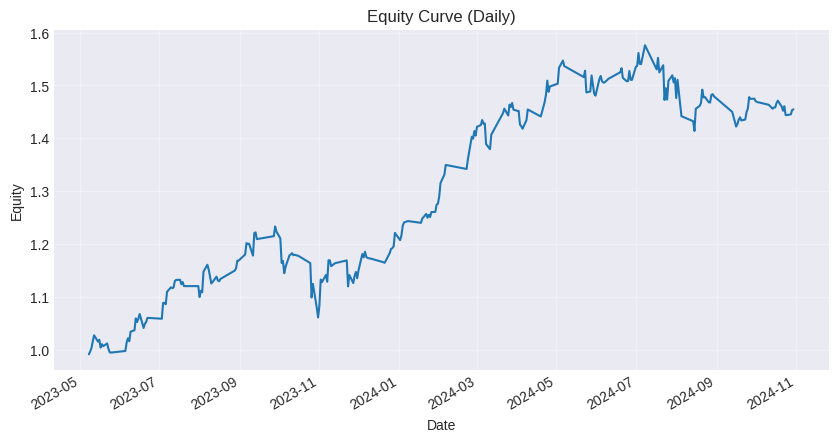

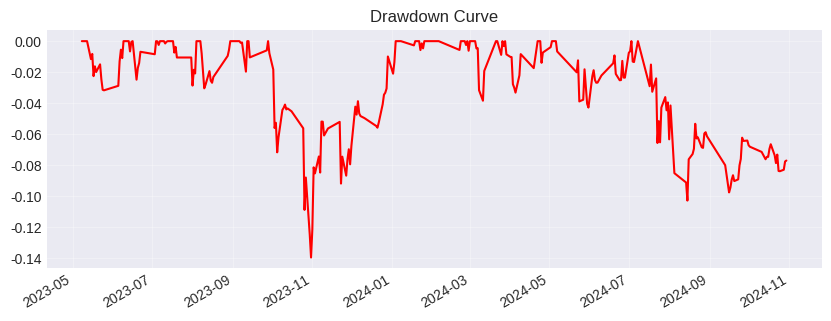

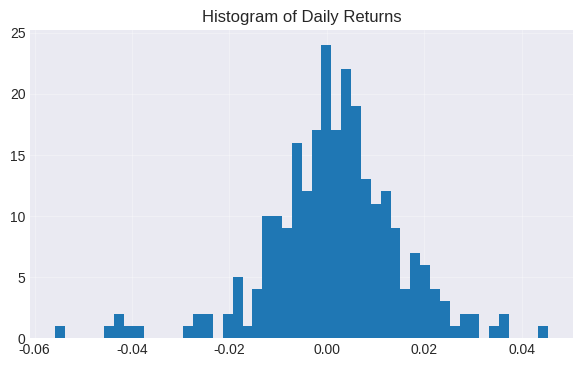

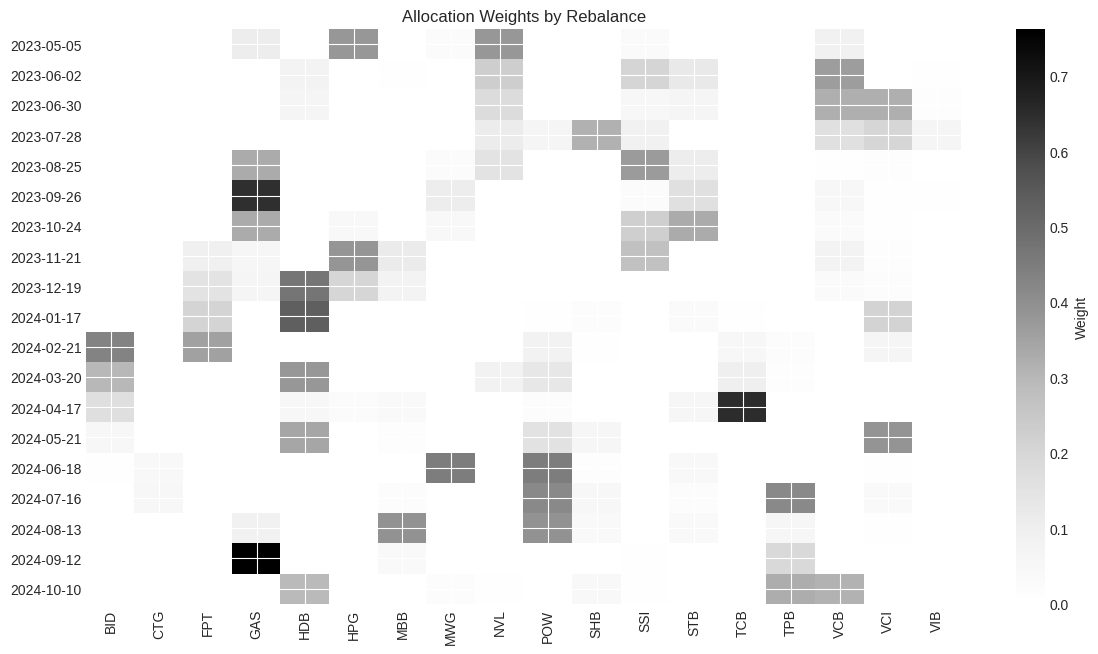

BID       CTG       FPT       GAS       HDB       HPG  \
date                                                                     
2023-05-05  0.000000  0.000000  0.000000  0.109640  0.000000  0.375632   
2023-06-02  0.000000  0.000000  0.000000  0.000000  0.073862  0.000000   
2023-06-30  0.000000  0.000000  0.000000  0.000000  0.059602  0.000000   
2023-07-28  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2023-08-25  0.000000  0.000000  0.000000  0.329197  0.000000  0.000000   
2023-09-26  0.000000  0.000000  0.000000  0.643200  0.000000  0.000000   
2023-10-24  0.000000  0.000000  0.000000  0.328271  0.000000  0.043930   
2023-11-21  0.000000  0.000000  0.090005  0.057344  0.000000  0.381951   
2023-12-19  0.000000  0.000000  0.146022  0.063566  0.468389  0.200501   
2024-01-17  0.000000  0.000000  0.205314  0.000000  0.529733  0.000000   
2024-02-21  0.431160  0.000000  0.352326  0.000000  0.000000  0.000000   
2024-03-20  0.296816  0.000000  0.000000  0.000000  0.376260  0.000000   
2024-04-17  0.166539  0.000000  0.000000  0.000000  0.048447  0.021573   
2024-05-21  0.050342  0.000000  0.000000  0.000000  0.340271  0.000000   
2024-06-18  0.008515  0.041196  0.000000  0.000000  0.000000  0.000000   
2024-07-16  0.000000  0.052838  0.000000  0.000000  0.000000  0.000000   
2024-08-13  0.000000  0.000000  0.000000  0.085435  0.000000  0.000000   
2024-09-12  0.000000  0.000000  0.000000  0.761459  0.000000  0.000000   
2024-10-10  0.000000  0.000000  0.000000  0.000000  0.294417  0.000000   

                 MBB       MWG       NVL       POW       SHB       SSI  \
date                                                                     
2023-05-05  0.000000  0.024495  0.375632  0.000000  0.000000  0.030797   
2023-06-02  0.008476  0.000000  0.226557  0.000000  0.000000  0.203126   
2023-06-30  0.000000  0.000000  0.176483  0.000000  0.000000  0.051625   
2023-07-28  0.000000  0.000000  0.111835  0.059963  0.314678  0.085858   
2023-08-25  0.000000  0.025916  0.147128  0.000000  0.000000  0.366351   
2023-09-26  0.000000  0.109867  0.000000  0.000000  0.000000  0.023194   
2023-10-24  0.000000  0.039806  0.000000  0.000000  0.000000  0.223335   
2023-11-21  0.114537  0.000000  0.000000  0.000000  0.000000  0.268719   
2023-12-19  0.072792  0.000000  0.000000  0.000000  0.000000  0.000000   
2024-01-17  0.000000  0.000000  0.000000  0.003690  0.016284  0.000000   
2024-02-21  0.000000  0.000000  0.000000  0.082668  0.004744  0.000000   
2024-03-20  0.000000  0.000000  0.082122  0.133099  0.001748  0.000000   
2024-04-17  0.037405  0.000000  0.000000  0.017011  0.000000  0.000000   
2024-05-21  0.013791  0.000000  0.000000  0.153065  0.054992  0.000000   
2024-06-18  0.000000  0.447845  0.000000  0.447845  0.010416  0.000000   
2024-07-16  0.015887  0.000000  0.000000  0.414955  0.046867  0.000000   
2024-08-13  0.390657  0.000000  0.000000  0.390657  0.036934  0.000000   
2024-09-12  0.038334  0.000000  0.000000  0.000000  0.002778  0.007873   
2024-10-10  0.000000  0.018717  0.003622  0.000000  0.040924  0.008756   

                 STB       TCB       TPB       VCB       VCI       VIB  \
date                                                                     
2023-05-05  0.000000  0.000000  0.000000  0.083797  0.000000  0.000006   
2023-06-02  0.122789  0.000000  0.000000  0.360874  0.000000  0.004316   
2023-06-30  0.060617  0.000000  0.000000  0.321053  0.321053  0.009567   
2023-07-28  0.000000  0.000000  0.000000  0.162531  0.199723  0.065413   
2023-08-25  0.109761  0.000000  0.000000  0.006829  0.014818  0.000000   
2023-09-26  0.158610  0.000000  0.000000  0.053137  0.006487  0.005505   
2023-10-24  0.328271  0.000000  0.000000  0.032277  0.004110  0.000000   
2023-11-21  0.000000  0.000000  0.000000  0.073263  0.014181  0.000000   
2023-12-19  0.000000  0.000000  0.000000  0.031433  0.017296  0.000000   
2024-01-17  0.027889  0.007789  0.000000  0.000000  0.209301  0.000000   
2024-02-21  0.00000

‚úÖ Saved allocations_by_rebalance.csv

Params: TH=0.55, TP=0.15, SL=-0.2, CAP=0.3, TOPK=7, SEED=42


In [138]:
# =========================
# FINAL REPORT ‚Äî MONTE CARLO 3-STAGE BACKTEST (STABLE)
# =========================
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict

# ==== 1. Fix seed ƒë·ªÉ ƒë·∫£m b·∫£o reproducibility ====

# ==== 2. Input ====
# df: DataFrame v·ªõi ['ticker','date','close','r1_calc','p_long']
# rebal_dates: list c√°c m·ªëc t√°i c√¢n b·∫±ng
assert {"ticker","date","r1_calc","p_long"}.issubset(df.columns)
assert len(rebal_dates) > 1

df = df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date","ticker"]).reset_index(drop=True)

# ==== 3. Hyperparams t·ªëi ∆∞u ====
THRESHOLD = 0.55
TP = 0.15
SL = -0.20
CAP = 0.30
TOPK = 7
WINDOW = 60
HOLD_DAYS = 20
BLOCK = 5
FEE = 0.001  # 0.1% round-turn

# ==== 4. Helper functions ====
def safe_mdd(equity_series):
    eq = pd.Series(equity_series).reset_index(drop=True)
    return float((eq / eq.cummax() - 1).min())

def annualized_stats(equity_curve, daily_dates):
    eq = pd.Series(equity_curve, index=pd.to_datetime(daily_dates))
    rets = eq.pct_change().dropna()
    if len(rets) == 0:
        return np.nan, np.nan, np.nan
    vol = rets.std() * np.sqrt(252)
    vol = float(max(vol, 1e-9))
    total_days = (eq.index[-1] - eq.index[0]).days
    years = total_days / 365.25 if total_days > 0 else np.nan
    cagr = float(eq.iloc[-1] ** (1/years) - 1) if years and years > 0 else np.nan
    sharpe = float(cagr / vol) if np.isfinite(cagr) and vol > 0 else np.nan
    return cagr, vol, sharpe

def monte_carlo_optimize(df_hist, p_long, n_scen=10000, block=BLOCK, tilt_scale=0.002):
    """Monte Carlo 3-stage: sinh 500 k·ªãch b·∫£n block bootstrap, tilt nh·∫π theo p_long."""
    n_assets = df_hist.shape[1]
    window = len(df_hist)
    n_blocks = max(window - block + 1, 1)
    blocks = [df_hist.iloc[i:i+block].values for i in range(n_blocks)]
    mu_hist = df_hist.mean().values
    drift = 0.5 * mu_hist + 0.5 * (p_long / (np.sum(p_long) + 1e-9)) * tilt_scale

    scen = []
    for _ in range(n_scen):
        idx = np.random.randint(0, n_blocks, size=max(1, HOLD_DAYS // block))
        s = np.vstack([blocks[i] for i in idx])
        s = np.clip(s + drift, -0.10, 0.10)
        scen.append(s)
    scen = np.stack(scen, axis=0)

    all_w = np.random.dirichlet(np.ones(n_assets), size=1000)
    best_idx, best_score = 0, -1e9
    for i, w in enumerate(all_w):
        port = (scen @ w).mean(axis=1)
        mu, sd = port.mean(), port.std() + 1e-6
        score = mu / sd
        if score > best_score:
            best_idx, best_score = i, score
    return all_w[best_idx]

# ==== 5. Backtest ====
def backtest_mc3stage_report(df, rebal_dates, threshold, tp, sl, cap, topk):
    daily_dates, daily_equity = [], []
    equity = 1.0
    weights_panel = []
    per_ticker_trades = defaultdict(list)
    tp_hits_total = sl_hits_total = total_trades = 0

    for d0 in rebal_dates[:-1]:
        d1 = d0 + np.timedelta64(HOLD_DAYS, 'D')

        pool = df[(df["date"] == d0) & (df["p_long"] > threshold)][["ticker","p_long"]]
        if pool.empty: continue
        pool = pool.nlargest(topk, "p_long")
        top = pool["ticker"].tolist()
        p = pool["p_long"].values

        # l·ªãch s·ª≠
        hist_cols = []
        for t in top:
            g = df[(df["ticker"] == t) & (df["date"] < d0)].tail(WINDOW)
            if len(g) < max(10, BLOCK):
                hist_cols = []
                break
            hist_cols.append(g.set_index("date")["r1_calc"])
        if len(hist_cols) != len(top): continue

        df_hist = pd.concat(hist_cols, axis=1)
        df_hist.columns = top

        w = monte_carlo_optimize(df_hist, p_long=p, n_scen=500)
        w = np.clip(w, 0, cap)
        if w.sum() <= 0: continue
        w = w / w.sum()

        weights_panel.append((pd.Timestamp(d0), dict(zip(top, w))))

        ret = df[(df["ticker"].isin(top)) & (df["date"] > d0) & (df["date"] <= d1)]
        if ret.empty: continue
        ret_mat = ret.pivot(index="date", columns="ticker", values="r1_calc").reindex(columns=top).fillna(0)
        cum_ret_mat = (1 + ret_mat).cumprod() - 1
        local_equity = equity
        active = np.ones(len(top), dtype=bool)

        for i, (dt, row) in enumerate(ret_mat.iterrows()):
            cum_now = cum_ret_mat.iloc[i].values
            hit_tp, hit_sl = cum_now > tp, cum_now < sl
            active = ~(hit_tp | hit_sl)
            day_ret = float(np.sum(row.values * w * active))
            local_equity *= (1 + day_ret)
            daily_dates.append(pd.Timestamp(dt))
            daily_equity.append(local_equity)

        for j, t in enumerate(top):
            tr = float(cum_ret_mat.iloc[-1, j])
            per_ticker_trades[t].append(tr)
            if tr > tp: tp_hits_total += 1
            if tr < sl: sl_hits_total += 1
            total_trades += 1

        equity = local_equity * (1 - 2 * FEE)

    cagr, vol, sharpe = annualized_stats(daily_equity, daily_dates)
    mdd = safe_mdd(daily_equity)
    win_rate = np.mean([x>0 for lst in per_ticker_trades.values() for x in lst]) if total_trades else None

    uniq = sorted({tk for _, d in weights_panel for tk in d.keys()})
    heat = np.zeros((len(weights_panel), len(uniq)))
    row_labels = []
    for i, (d0, wdict) in enumerate(weights_panel):
        row_labels.append(str(pd.Timestamp(d0).date()))
        for j, tk in enumerate(uniq):
            heat[i, j] = wdict.get(tk, 0.0)

    report = {
        "weights_panel": weights_panel,
        "weights_heat": heat,
        "weight_row_labels": row_labels,
        "weight_col_labels": uniq,
        "equity_series": pd.Series(daily_equity, index=pd.to_datetime(daily_dates)).sort_index(),
        "cagr": cagr, "vol": vol, "sharpe": sharpe, "mdd": mdd,
        "tp_hits": tp_hits_total, "sl_hits": sl_hits_total,
        "total_trades": total_trades, "win_rate": win_rate,
    }
    return report

# ==== 6. Run ====
rep = backtest_mc3stage_report(df, rebal_dates, THRESHOLD, TP, SL, CAP, TOPK)

# ==== 7. Visualization ====
summary = pd.DataFrame({
    "Metric": ["Total trades","TP hits","SL hits","Win rate","CAGR","Volatility","Sharpe","MDD"],
    "Value": [
        rep["total_trades"], rep["tp_hits"], rep["sl_hits"],
        f"{rep['win_rate']*100:.2f}%" if rep['win_rate'] else None,
        f"{rep['cagr']*100:.2f}%", f"{rep['vol']*100:.2f}%", f"{rep['sharpe']:.2f}", f"{rep['mdd']*100:.2f}%"
    ]
})
print(summary.to_string(index=False))

# === Equity curve ===
plt.figure(figsize=(10,5))
rep["equity_series"].plot()
plt.title("Equity Curve (Daily)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.grid(alpha=0.3); plt.show()

# === Drawdown ===
dd = rep["equity_series"]/rep["equity_series"].cummax() - 1
plt.figure(figsize=(10,3.5))
dd.plot(color='r'); plt.title("Drawdown Curve"); plt.grid(alpha=0.3); plt.show()

# === Histogram of daily returns ===
rets = rep["equity_series"].pct_change().dropna()
plt.figure(figsize=(7,4))
plt.hist(rets, bins=50); plt.title("Histogram of Daily Returns")
plt.grid(alpha=0.3); plt.show()

# === Weights heatmap ===
if rep["weights_heat"].size > 0:
    plt.figure(figsize=(12, max(4, 0.35*rep["weights_heat"].shape[0])))
    plt.imshow(rep["weights_heat"], aspect="auto", interpolation="nearest")
    plt.colorbar(label="Weight")
    plt.title("Allocation Weights by Rebalance")
    plt.yticks(ticks=np.arange(len(rep["weight_row_labels"])), labels=rep["weight_row_labels"])
    plt.xticks(ticks=np.arange(len(rep["weight_col_labels"])), labels=rep["weight_col_labels"], rotation=90)
    plt.tight_layout(); plt.show()

# ==== 8. Xu·∫•t b·∫£ng weights cho 19 chu k·ª≥ ====
rows, all_tickers = [], sorted(rep["weight_col_labels"])
for d0, wdict in rep["weights_panel"]:
    row = {"date": pd.to_datetime(d0)}
    for tk in all_tickers:
        row[tk] = wdict.get(tk, 0.0)
    row["sum_weight"] = sum(wdict.values())
    rows.append(row)

weights_df = pd.DataFrame(rows).set_index("date").sort_index()
display(weights_df)
weights_df.to_csv("/kaggle/working/allocations_by_rebalance.csv")
print("‚úÖ Saved allocations_by_rebalance.csv")

print(f"\nParams: TH={THRESHOLD}, TP={TP}, SL={SL}, CAP={CAP}, TOPK={TOPK}, SEED={SEED}")
